In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 11546041


In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid = 11546041

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lcc_tess = sr.download_all()
lc_tess = lcc_tess.stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 2 data products.

 #     mission     year   author  exptime target_name distance proposal_id
                                     s                 arcsec             
--- -------------- ---- --------- ------- ----------- -------- -----------
  0 TESS Sector 03 2018      SPOC     120    11546041      0.0     G011154
  1 TESS Sector 30 2020 TESS-SPOC     600    11546041      0.0         N/A

17222

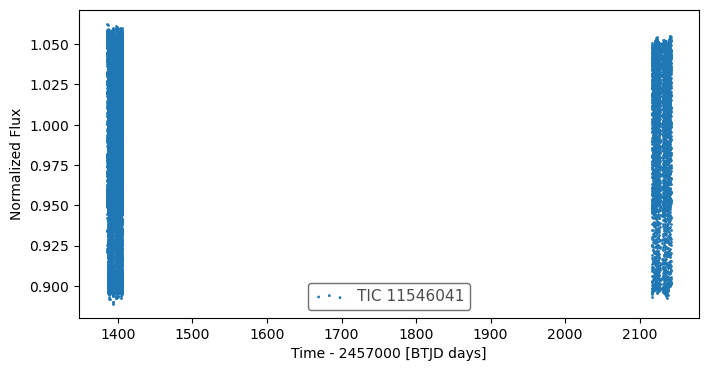

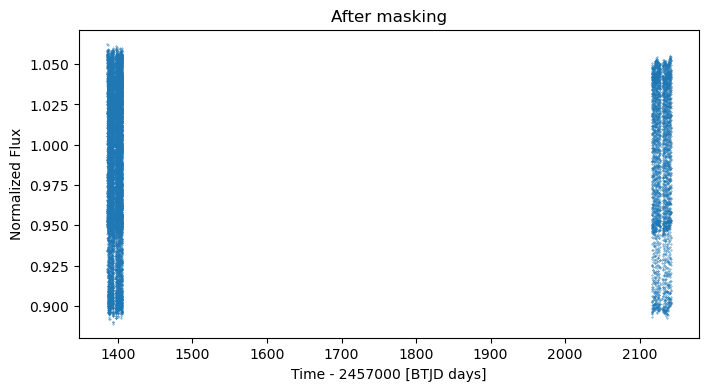

In [5]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
# mask = flux < 0.85    # remove occassional outliers

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

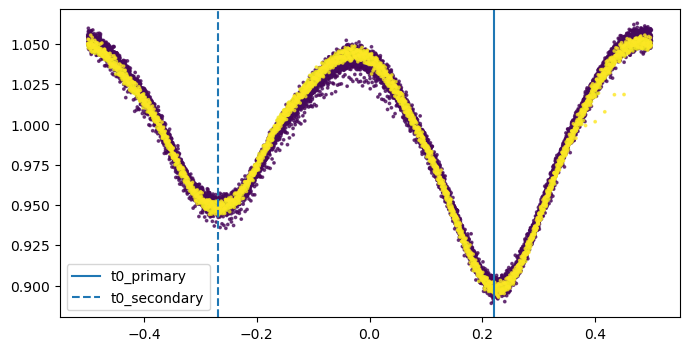

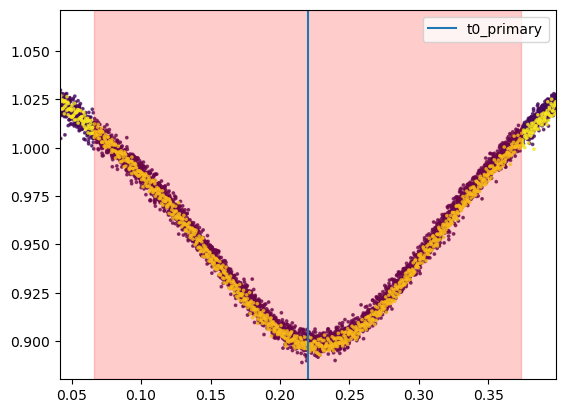

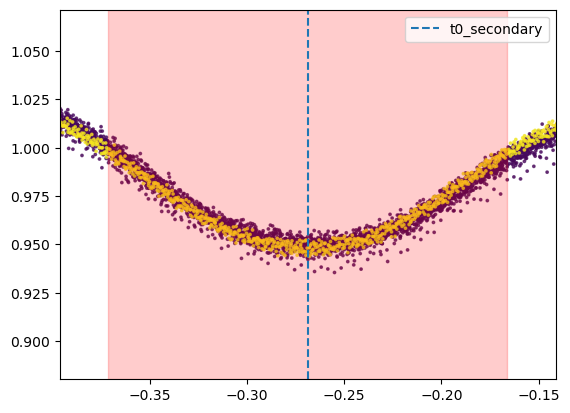

In [69]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# epoch=1382.2594, duration_hr=2.2821, period=0.406876, label="s0003-s0003:TCE2",
# epoch=1382.0546, duration_hr=1.6127, period=0.406938, label="s0003-s0003:TCE1",
# VSX: 0.406798 
# LS (nterms=2, frequency_factor=50): 0.40679628555661607
# MCMC on df_primary:  0.40679616080208214

# FILL-IN THE eclipse epoch / period, 
period = 0.406796  # MCMC

t0_primary = 1382.2594
t0_secondary = 1382.0546 + 0.006  # apply offset after visual inspection


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 3.0
duration_hr_secondary = 2.0

# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
plt.xlim(t1_s - 0.025, t4_s + 0.025);
plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
plt.legend();
# plt.ylim(0.975, 1.005);
plt.show()

### Compare folded plots across sectors

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
# show data to visualize what's changed in each step below
data  

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

Primary:   1385.920564 0.21991366680084679
window_width_p (phase): 0.36873518913656966
Secondary: 1385.7217640000001 -0.2687833705345546
window_width_s (phase): 0.24582345942437978


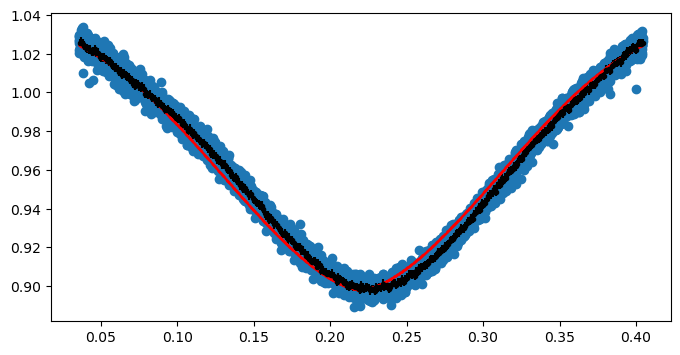

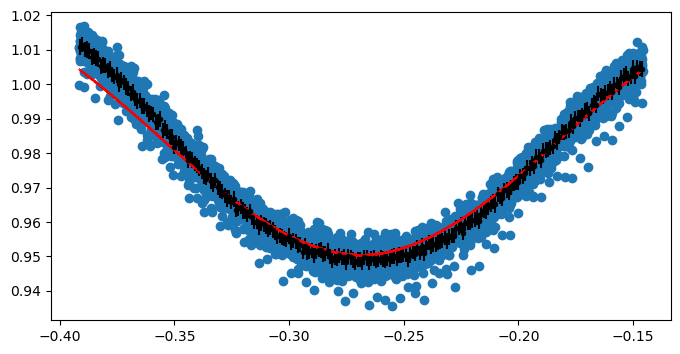

In [70]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 1.2 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 1.2 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1.038, -0.14, midpoint_p, 0.102, 0.80]
start_vals_s = [1.025, -0.0745, midpoint_s, 0.085, 0.95]

# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
if t0_secondary is not None:
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

In [ ]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [03:19<00:00,  5.02it/s]


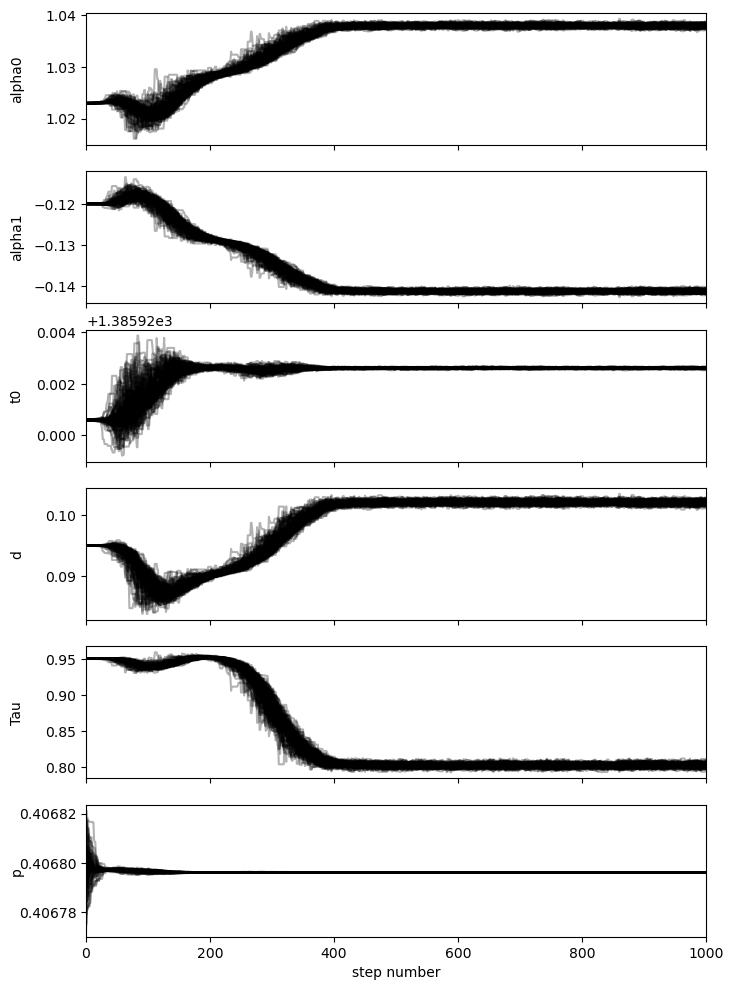

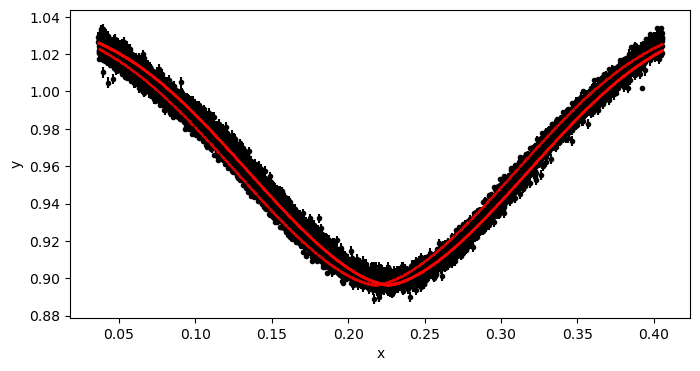

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0379565127218466, -0.14136175914503812, 1385.922608165834, 0.10210853789941973, 0.802485072659767, 0.40679616080208214
std_p: 1.4622657797968742e-08


In [35]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()
        
    # MCMC result
    # mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0379565127218466, -0.14136175914503812, 1385.922608165834, 0.10210853789941973, 0.802485072659767, 0.40679616080208214
    # std_p: 1.4622657797968742e-08    
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.023, -0.12, t0_primary, 0.095, 0.95, 0.406798],
        nruns=1000, discard=600, 
        # nruns=20, discard=1, 
        pool=-1,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 5 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 14.05it/s]


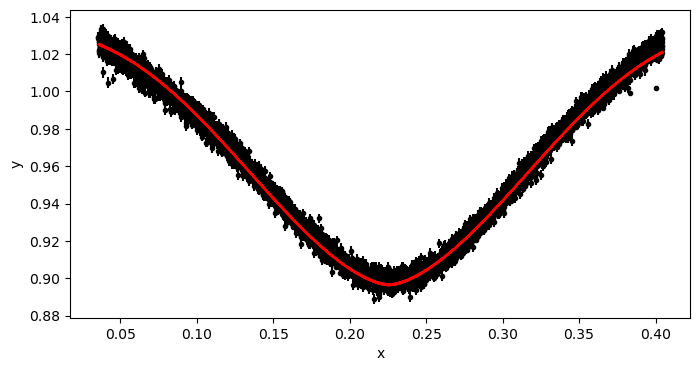

emcee parallel enabled, use 5 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.36it/s]


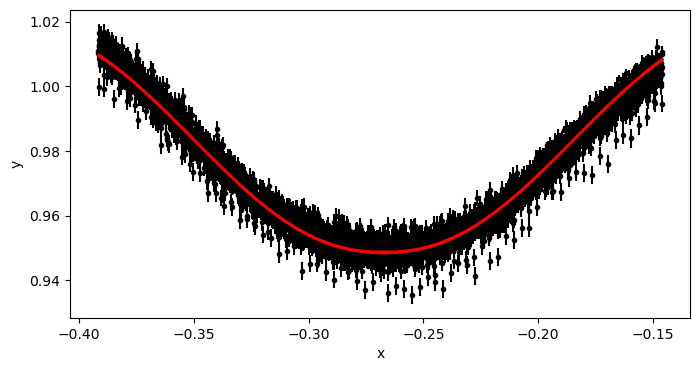

In [52]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, pool=-1, plot_chains = False, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, pool=-1, plot_chains = False, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data
        mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0358729768929278, -0.13914926145665393, 0.22542871232877554, 0.10026184397000065, 0.8121160969171446
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0230420602910246, -0.07427046987659028, -0.26743441661920664, 0.07309627036183572, 1.123937393762159

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [71]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0358729768929278, -0.13914926145665393, 0.22542871232877554, 0.10026184397000065, 0.8121160969171446
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0230420602910246, -0.07427046987659028, -0.26743441661920664, 0.07309627036183572, 1.123937393762159


1858

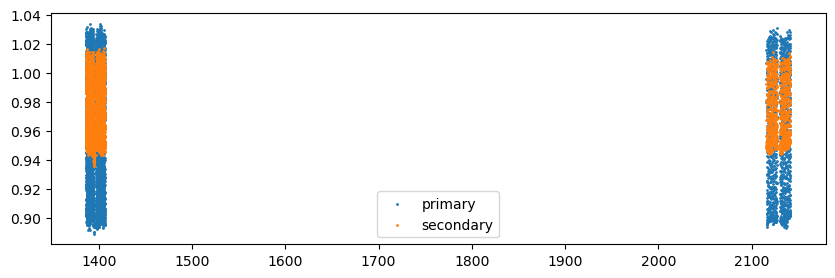

In [72]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1385.920564 0.406796 1385.920564


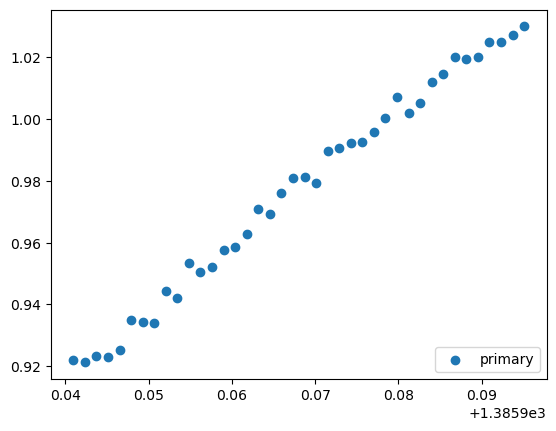

1385.920564 0.406796 1386.32736


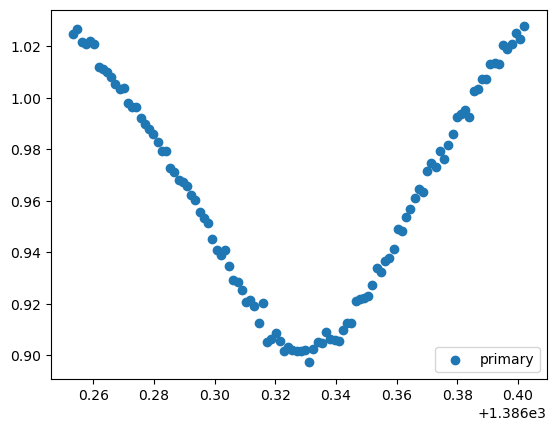

1385.920564 0.406796 1386.734156


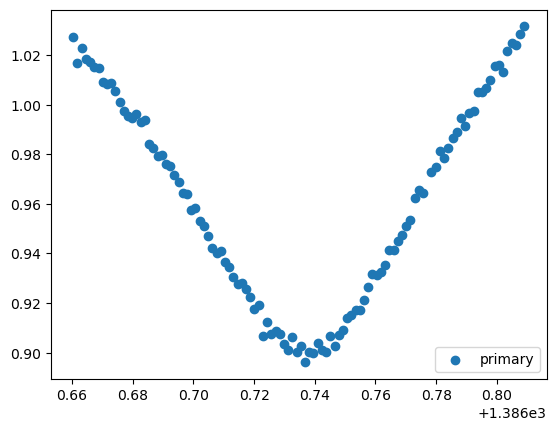

1385.7217640000001 0.406796 1385.7217640000001


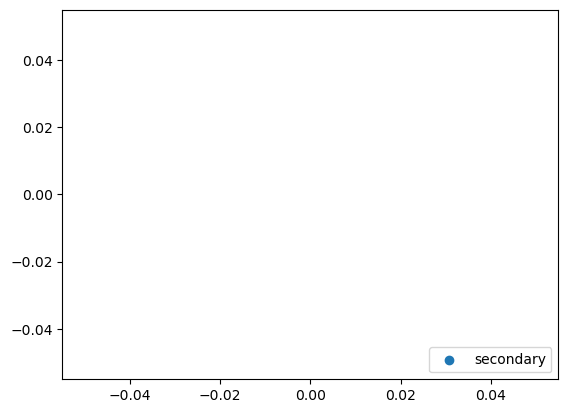

1385.7217640000001 0.406796 1386.12856


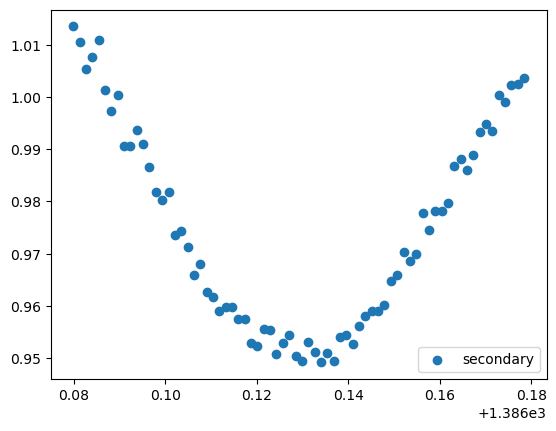

1385.7217640000001 0.406796 1386.535356


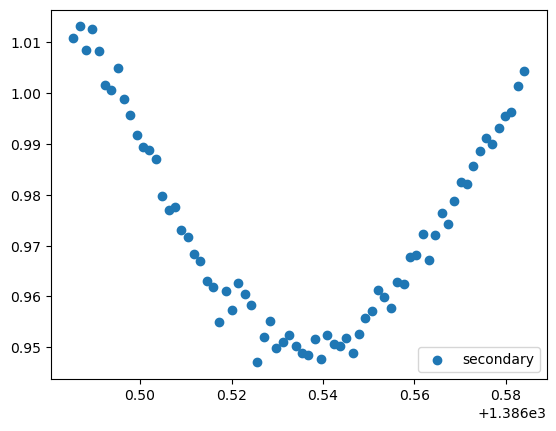

In [73]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

In [65]:
# # to test min num points for TESS-SPOC
# data_primary = data_primary[data_primary.time > 2100]
# data_secondary = data_secondary[data_secondary.time > 2100]

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
1386.734156 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 369.21it/s]


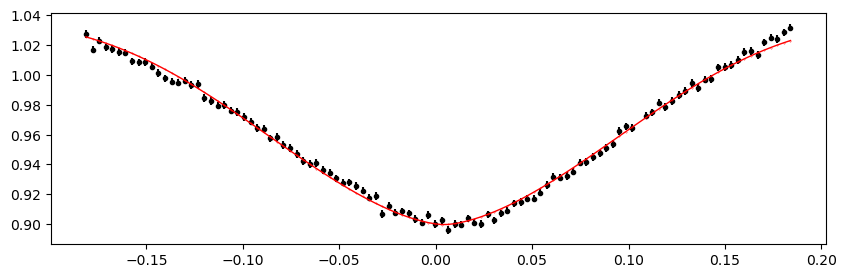

1387.140952 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.10it/s]


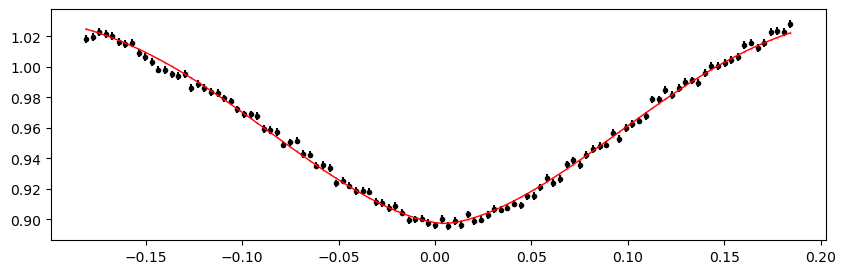

1387.547748 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 374.50it/s]


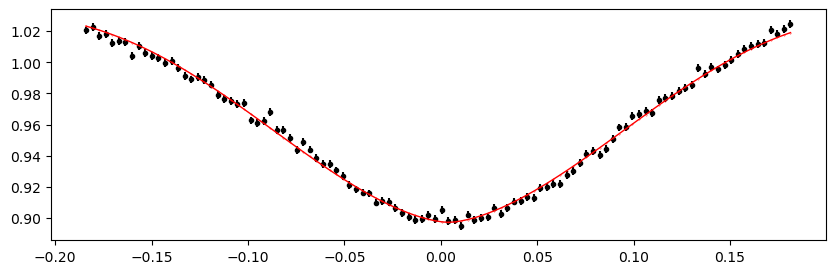

1387.954544 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 369.32it/s]


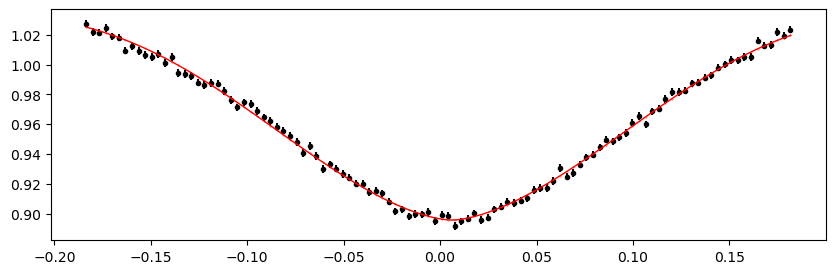

1388.36134 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 369.94it/s]


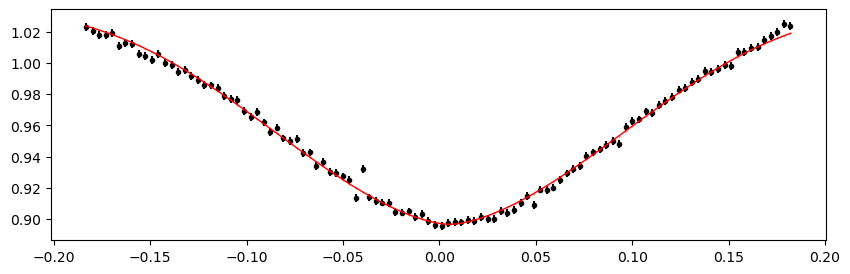

1388.768136 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 370.23it/s]


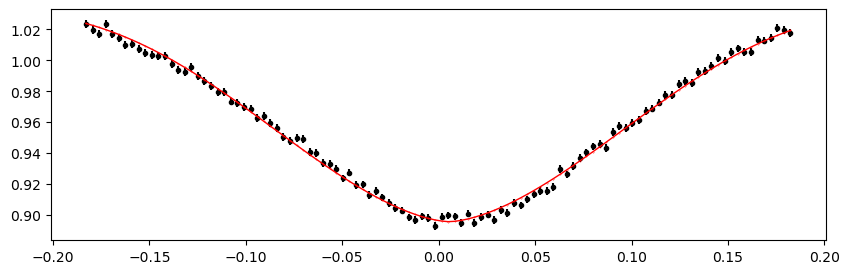

1389.1749320000001 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.27it/s]


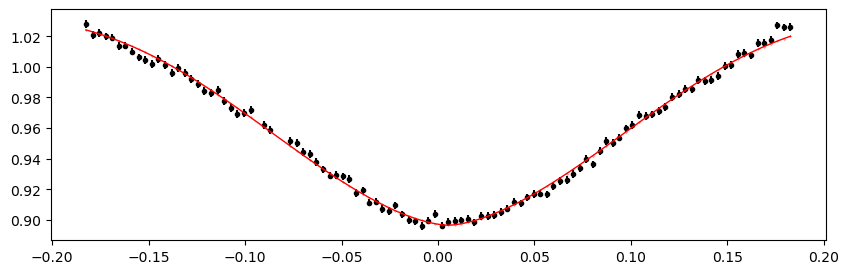

1389.581728 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.73it/s]


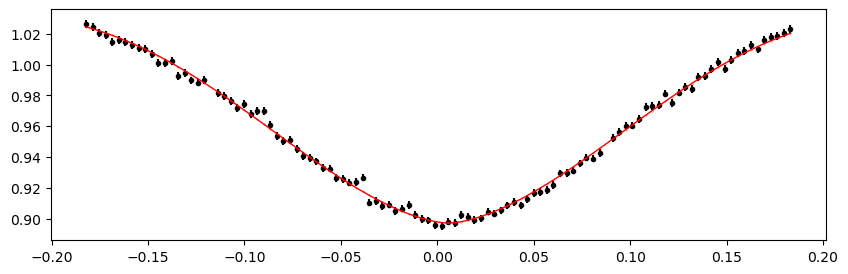

1389.988524 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 373.31it/s]


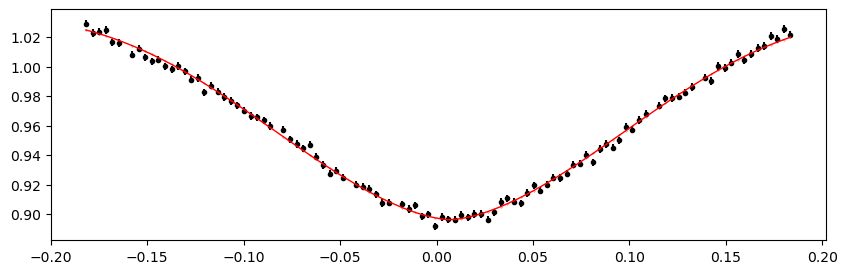

1390.39532 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.34it/s]


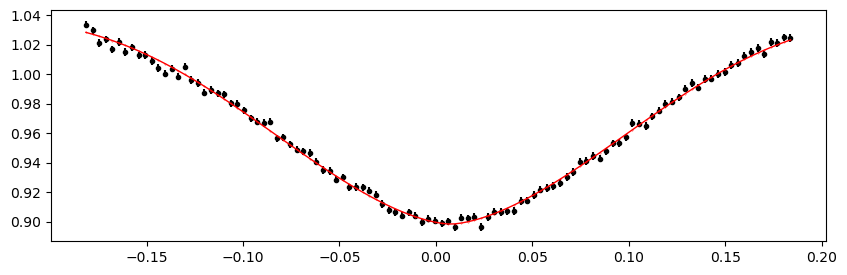

1390.802116 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.95it/s]


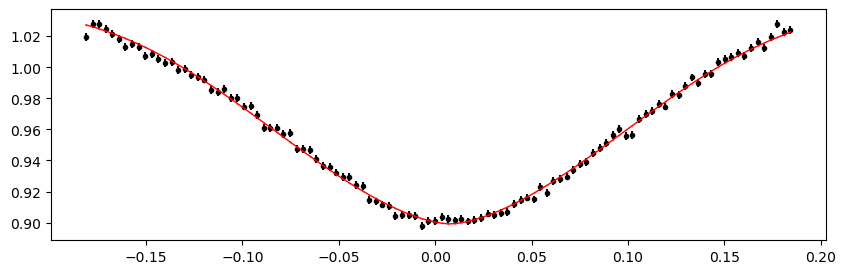

1391.208912 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.51it/s]


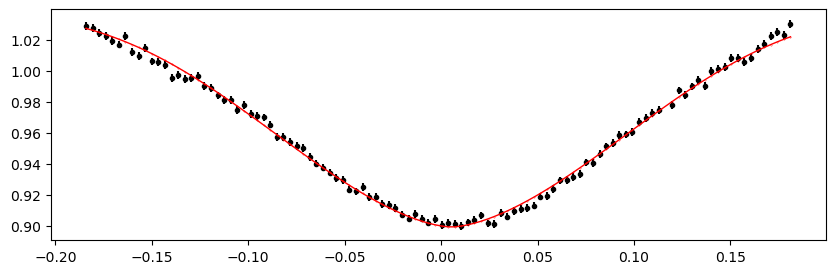

1391.615708 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.57it/s]


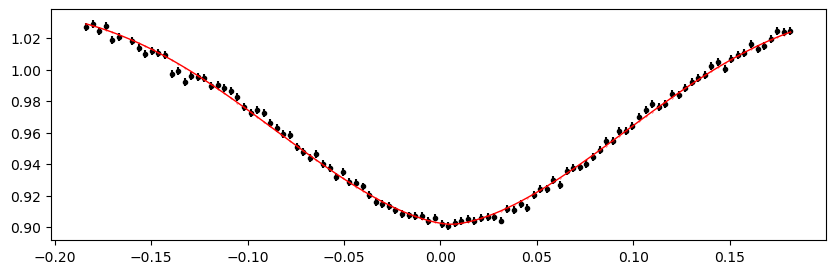

1392.022504 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 369.61it/s]


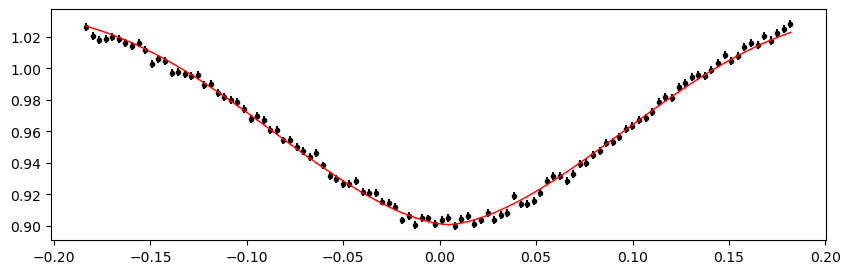

1392.4293 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 370.91it/s]


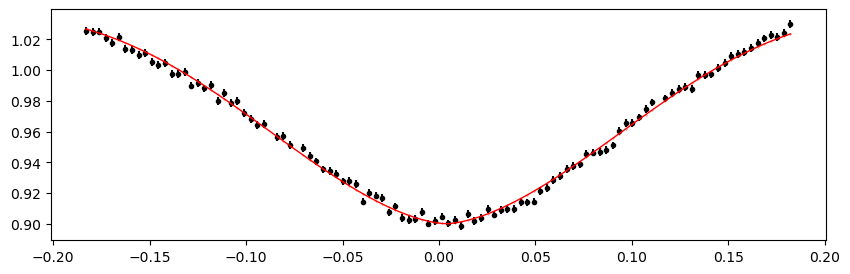

1392.836096 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.61it/s]


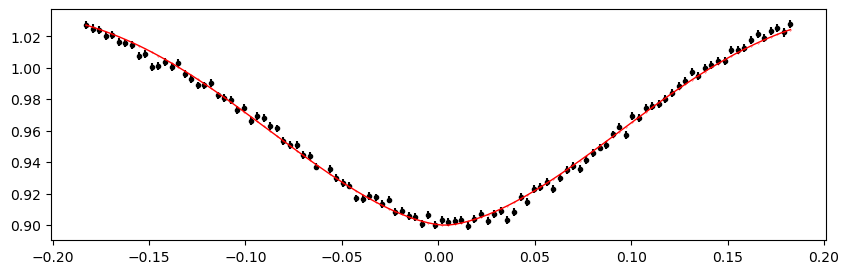

1393.242892 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.58it/s]


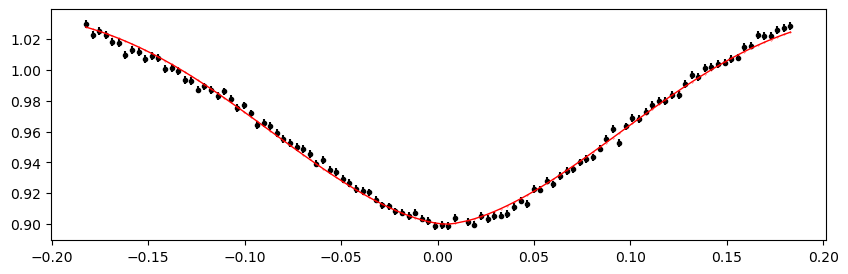

1393.649688 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.18it/s]


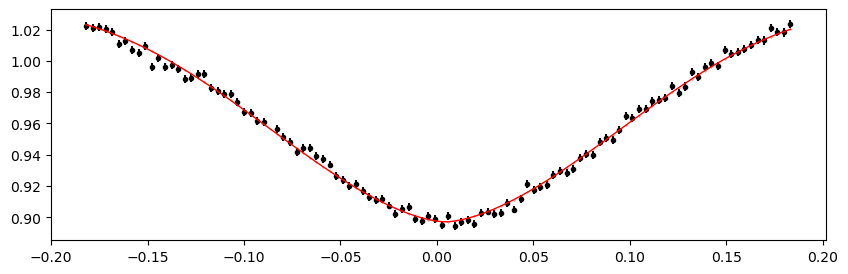

1394.056484 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.65it/s]


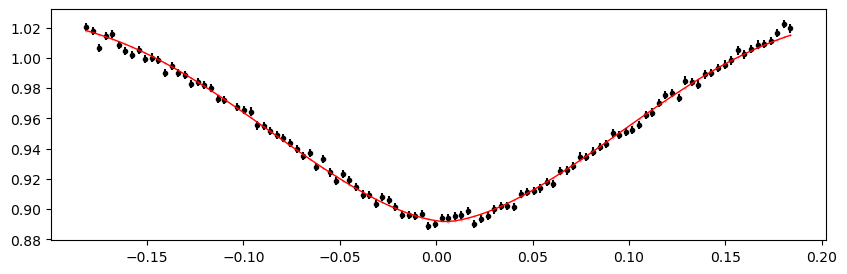

Time 1394.46328 does not have enough data points: 2
1396.904056 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.10it/s]


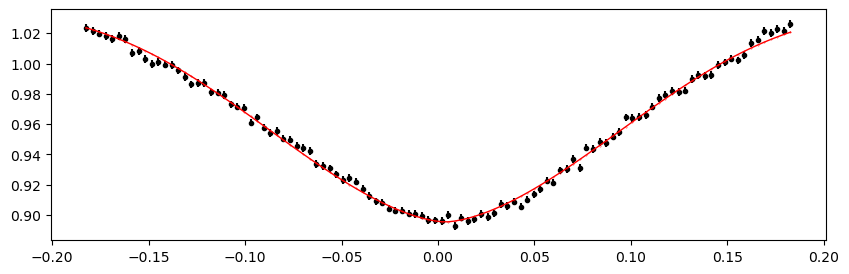

1397.310852 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.64it/s]


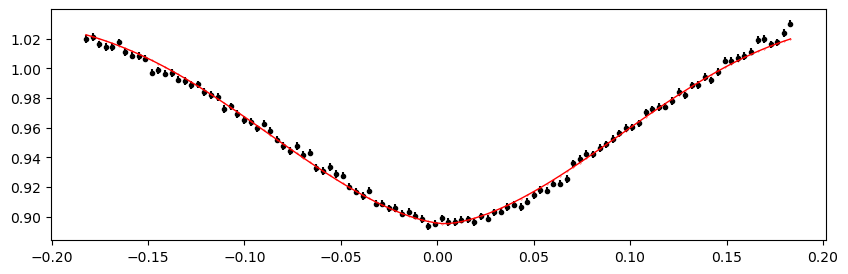

1397.717648 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 356.90it/s]


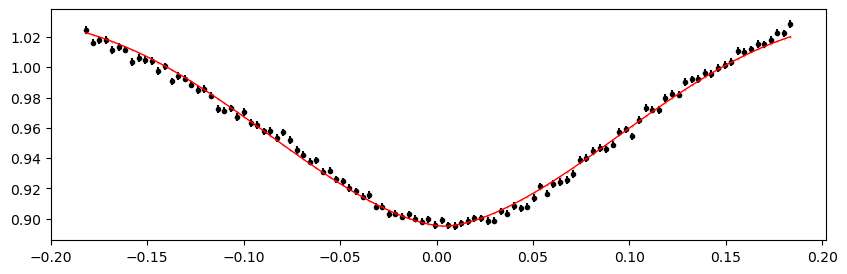

1398.124444 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.11it/s]


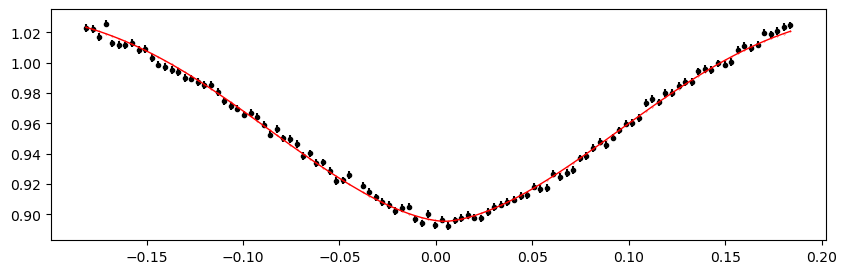

1398.53124 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.25it/s]


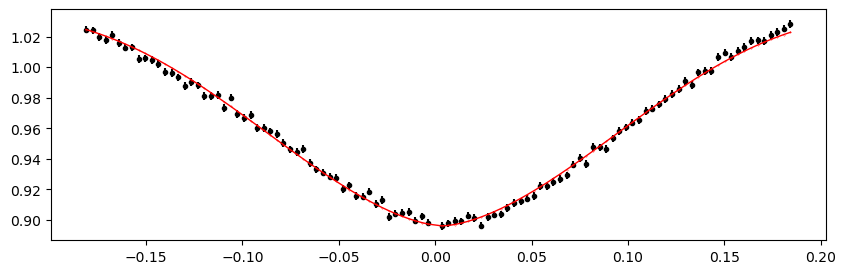

1398.938036 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 351.94it/s]


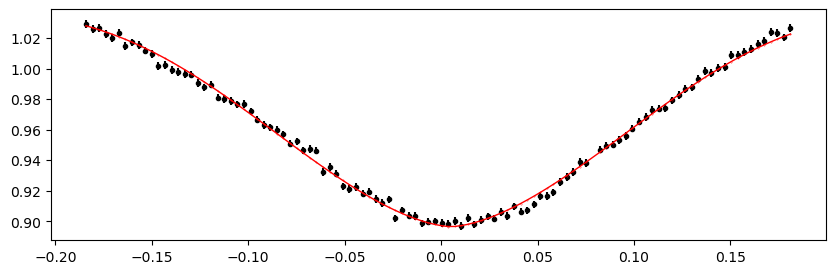

1399.344832 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.94it/s]


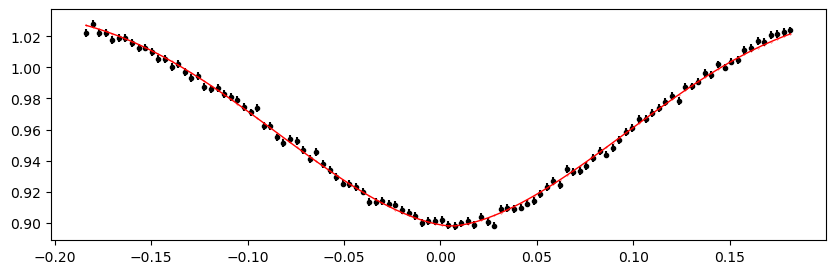

1399.751628 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.76it/s]


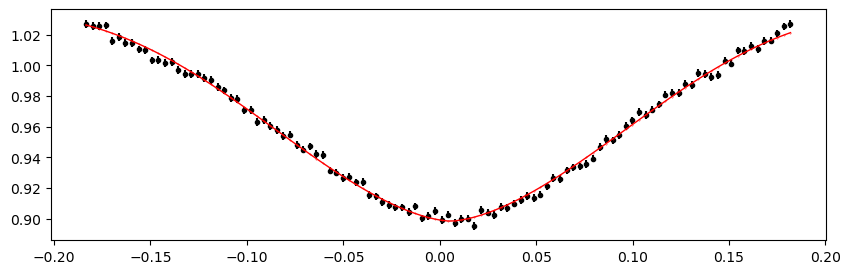

1400.158424 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.71it/s]


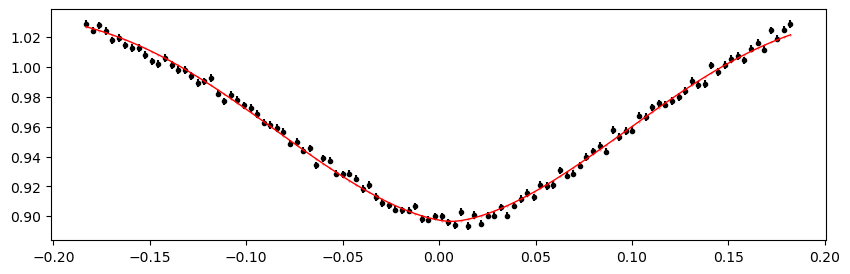

1400.56522 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 369.95it/s]


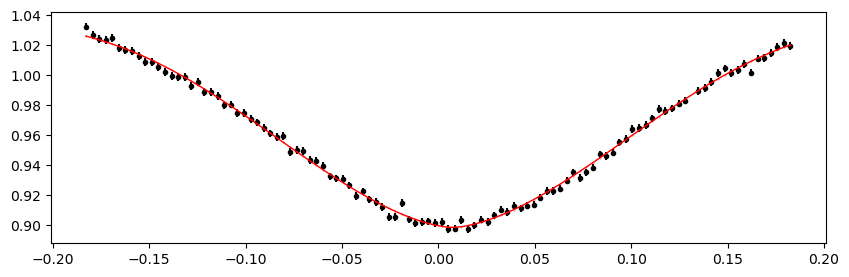

1400.972016 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.17it/s]


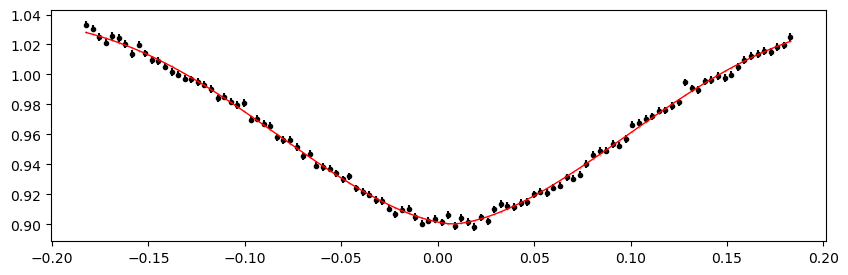

1401.378812 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 353.86it/s]


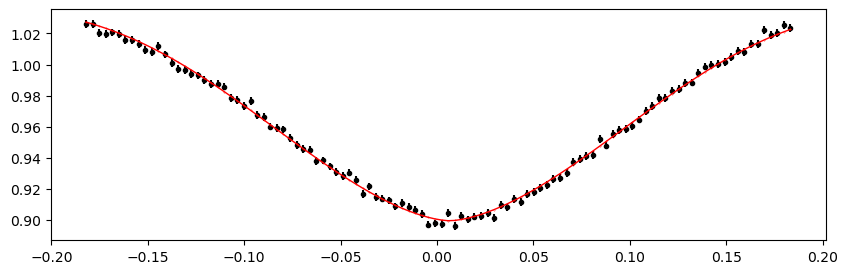

1401.785608 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.65it/s]


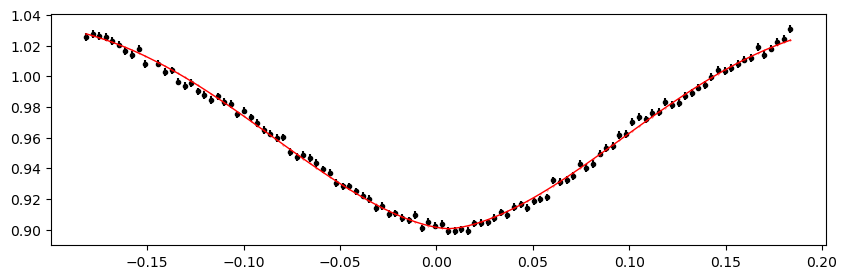

1402.1924040000001 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.69it/s]


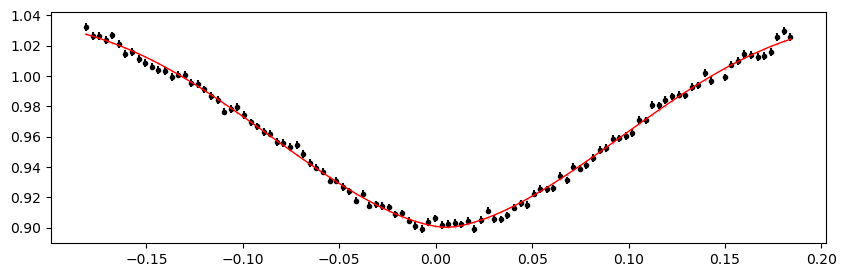

1402.5992 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.39it/s]


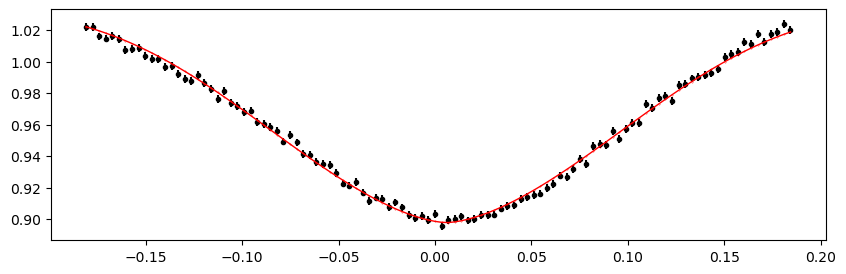

1403.005996 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 354.65it/s]


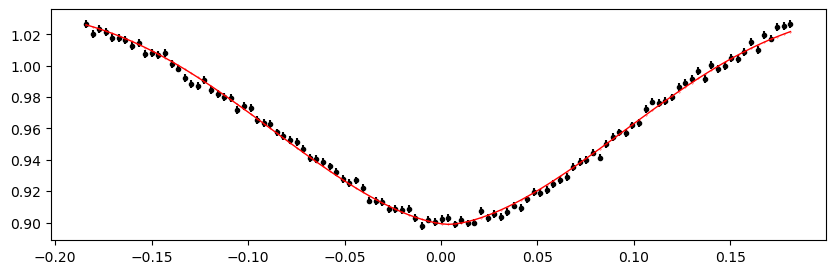

1403.412792 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 355.43it/s]


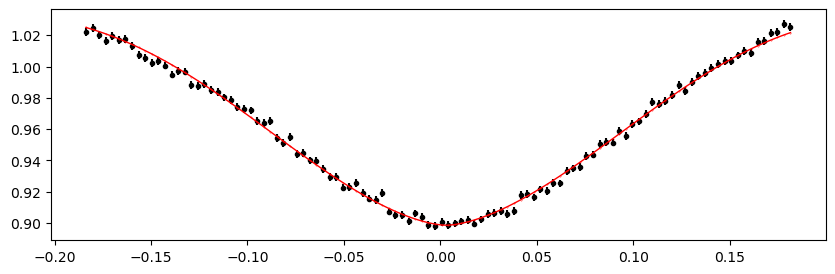

1403.819588 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.31it/s]


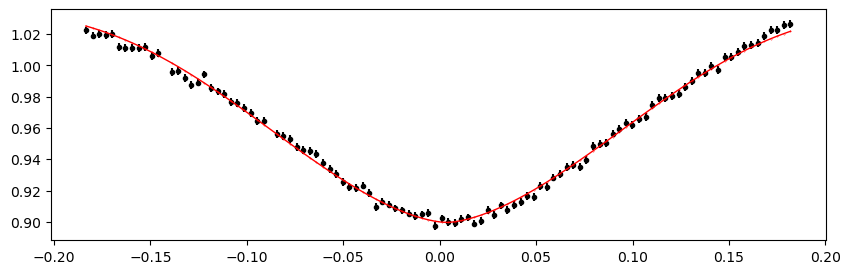

1404.226384 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 351.12it/s]


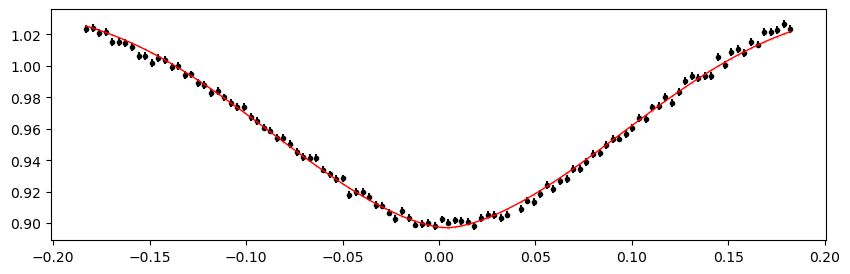

1404.63318 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 352.64it/s]


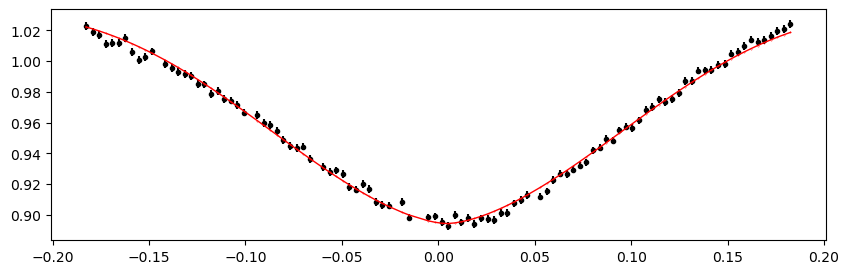

1405.039976 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 356.79it/s]


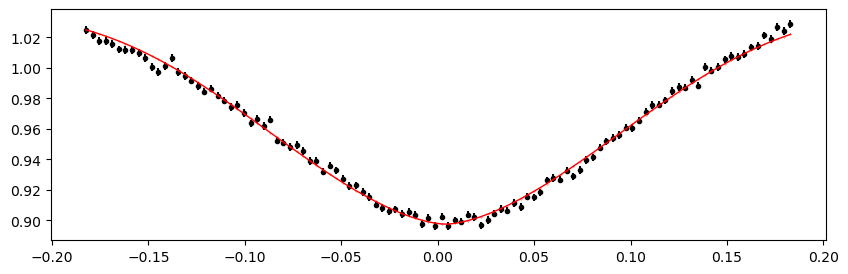

1405.446772 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 362.57it/s]


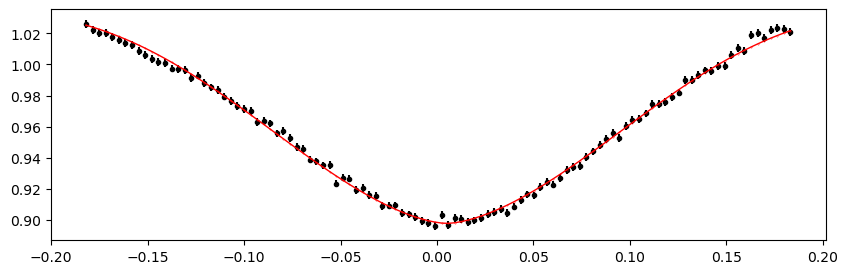

1405.853568 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.88it/s]


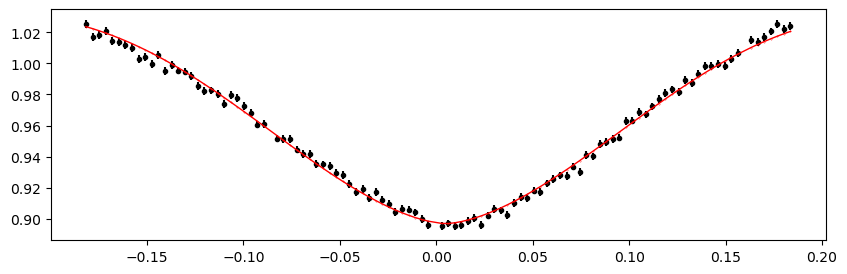

1406.260364 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.59it/s]


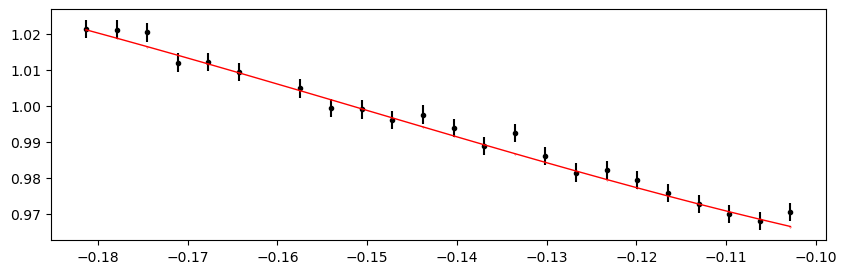

2116.119384 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.93it/s]


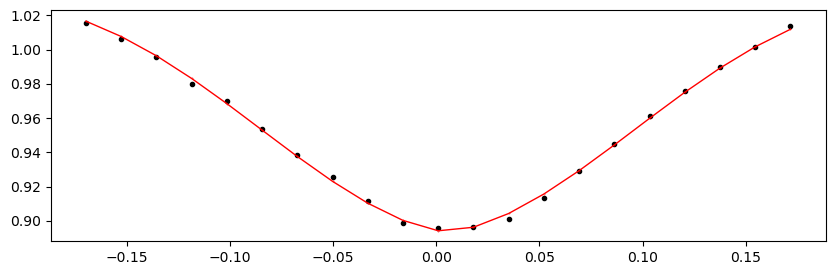

2116.52618 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.42it/s]


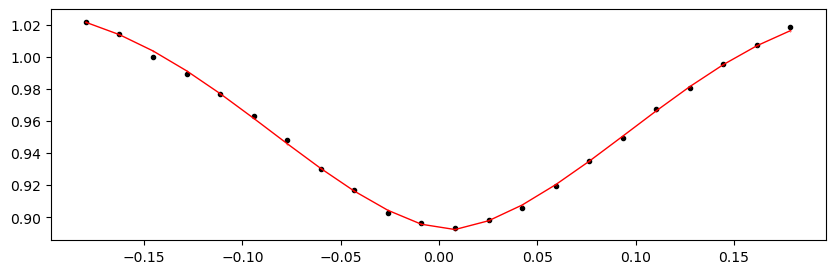

2116.932976 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.28it/s]


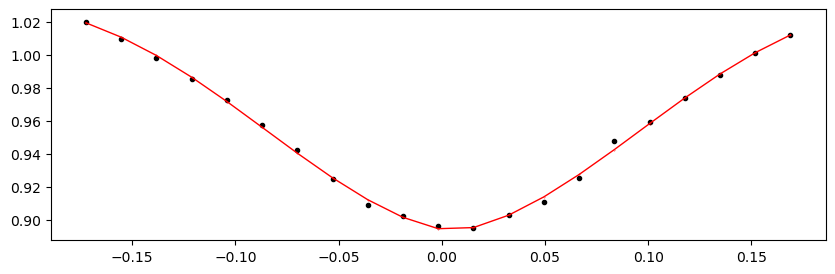

2117.3397720000003 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.30it/s]


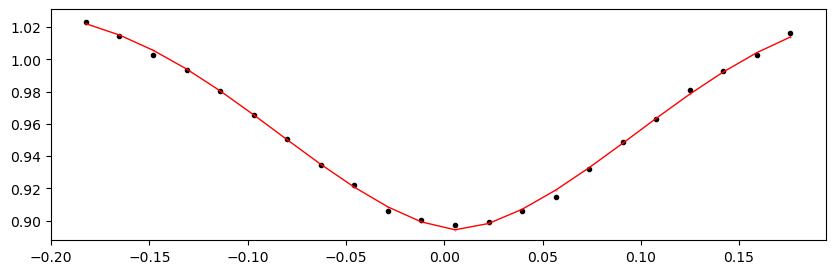

2117.746568 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.99it/s]


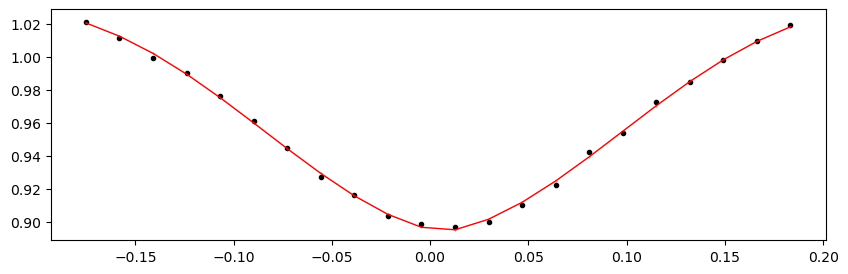

2118.153364 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.01it/s]


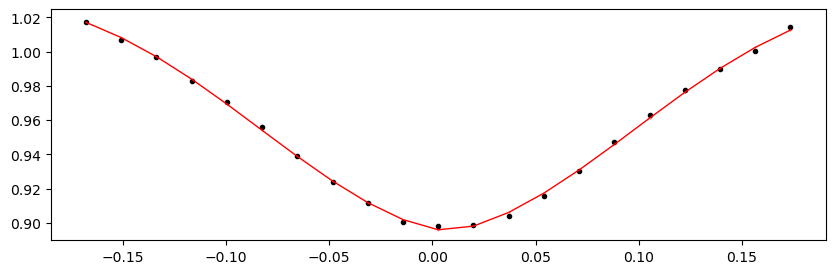

2118.56016 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.80it/s]


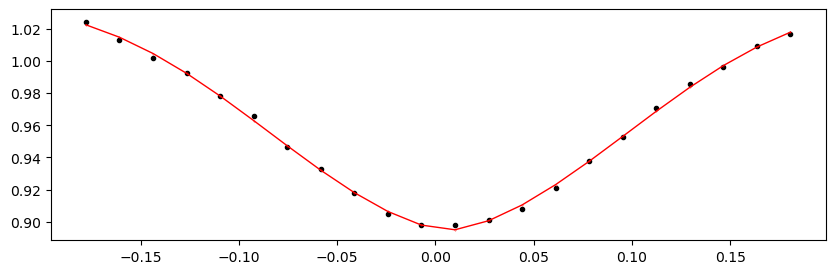

2118.966956 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.51it/s]


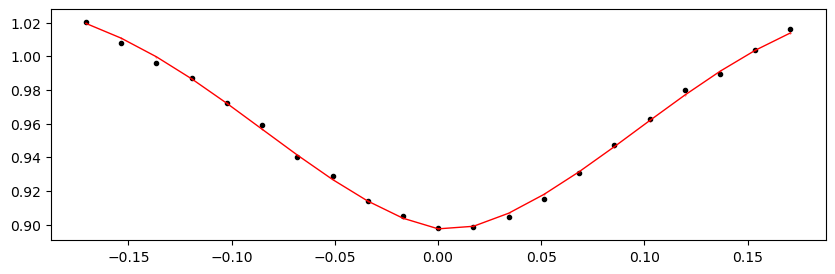

2119.373752 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.59it/s]


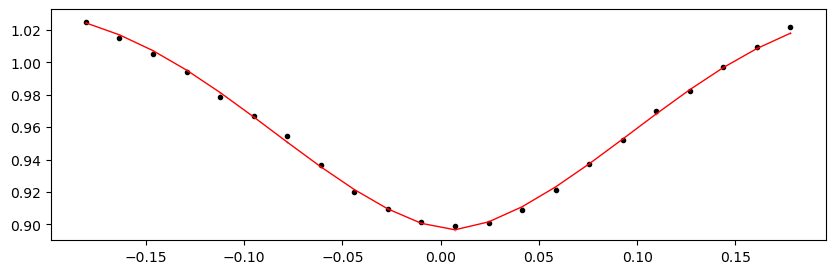

2119.7805479999997 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.77it/s]


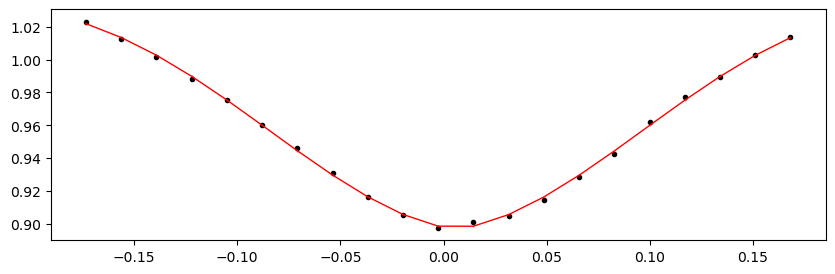

2120.187344 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.99it/s]


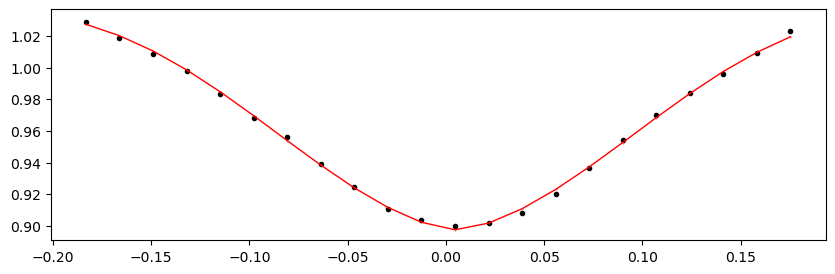

2120.59414 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.57it/s]


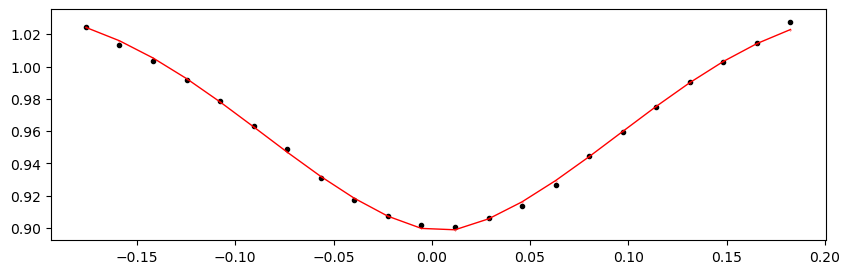

2121.000936 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.83it/s]


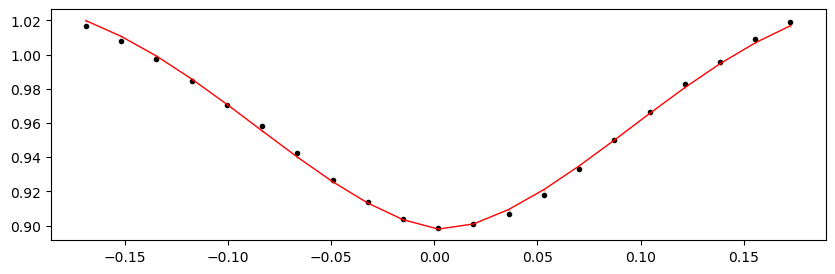

2121.407732 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.44it/s]


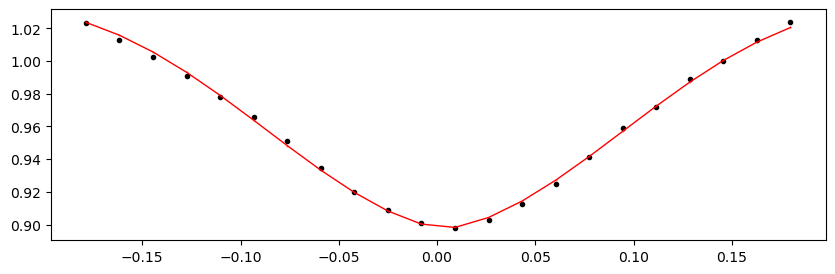

2121.814528 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.09it/s]


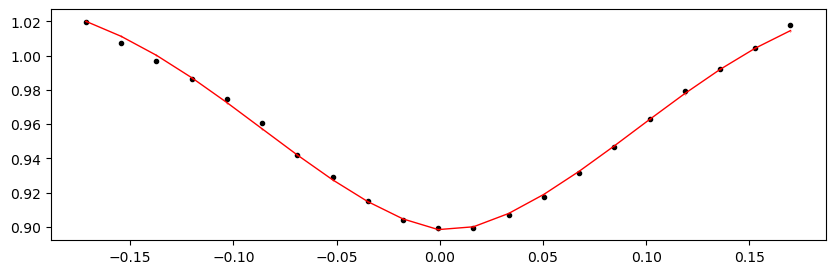

2122.221324 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.34it/s]


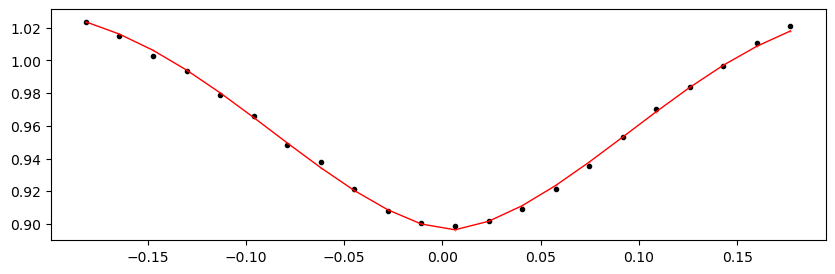

2122.62812 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.93it/s]


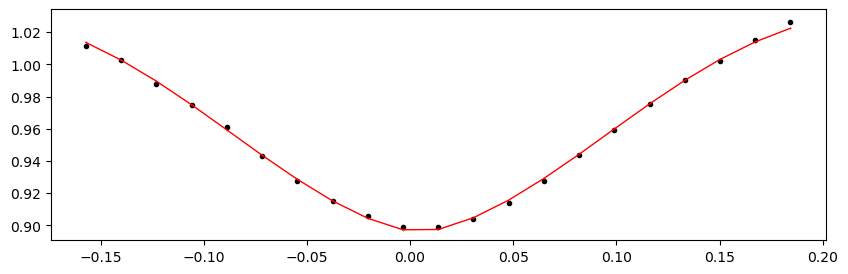

2123.034916 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.48it/s]


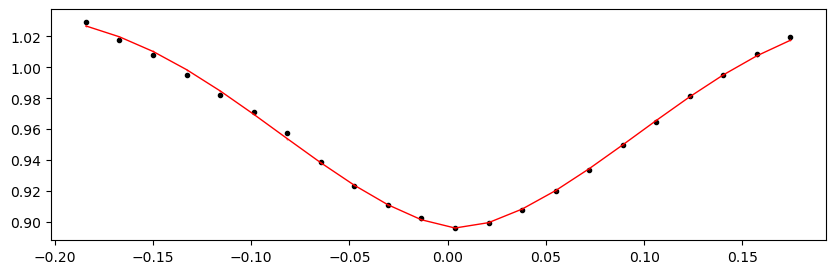

2123.441712 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.28it/s]


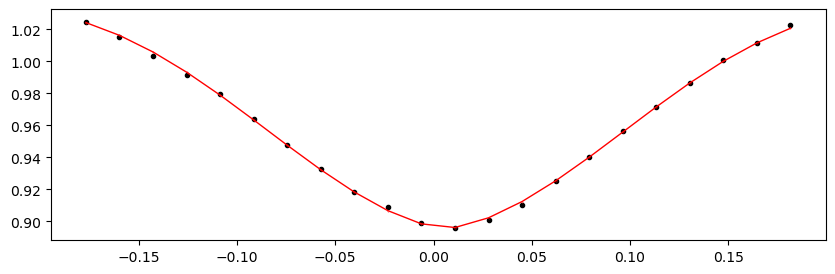

2123.848508 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.83it/s]


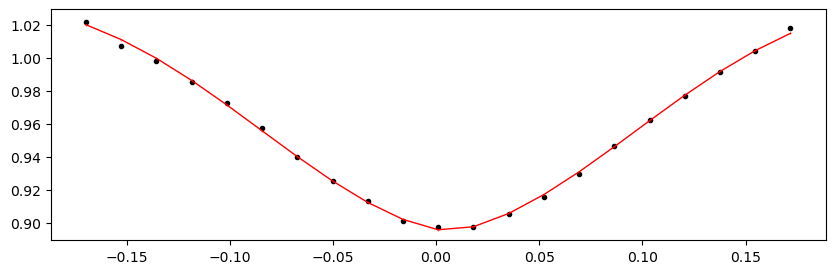

2124.2553040000003 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.34it/s]


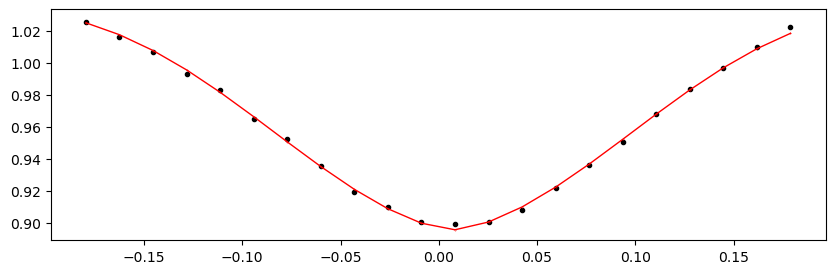

2124.6621 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.49it/s]


2125.0688959999998 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.84it/s]


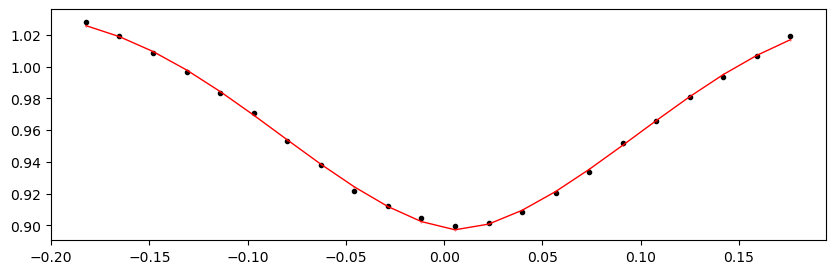

2125.475692 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.41it/s]


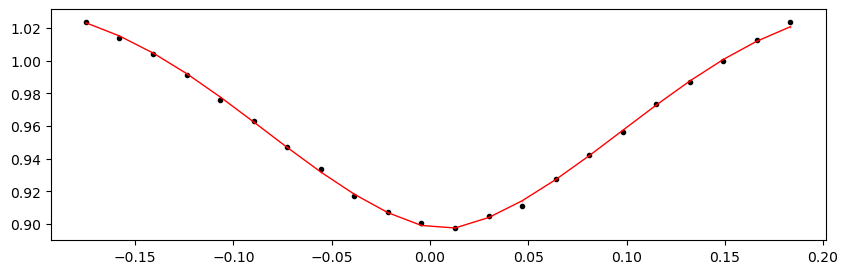

2125.882488 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.28it/s]


2126.289284 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.48it/s]


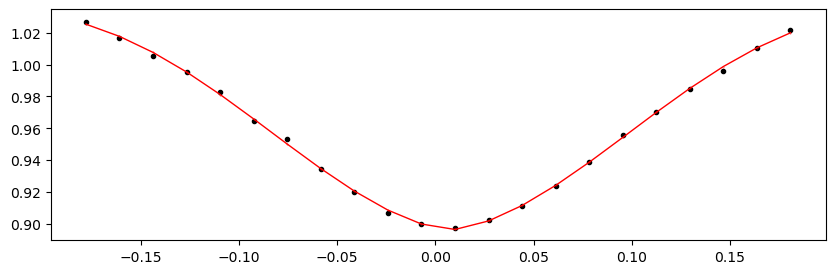

2126.69608 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.25it/s]


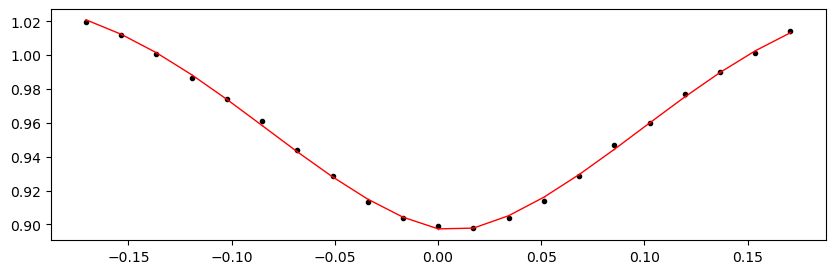

2127.102876 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.92it/s]


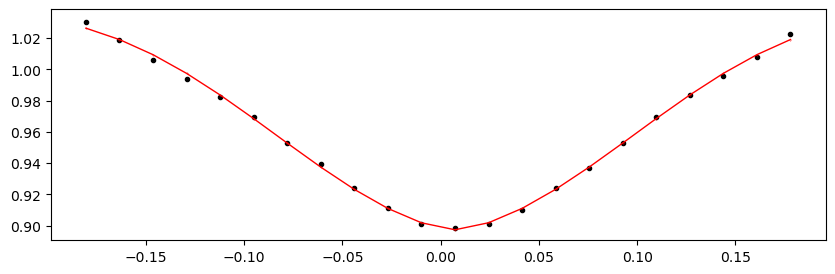

Time 2127.509672 does not have enough data points: 1
2130.357244 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.04it/s]


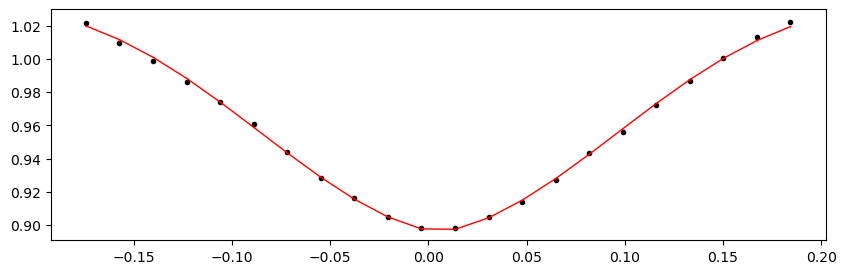

2130.76404 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.47it/s]


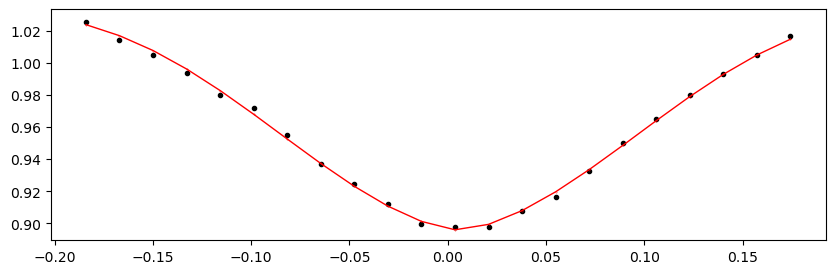

2131.1708360000002 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.95it/s]


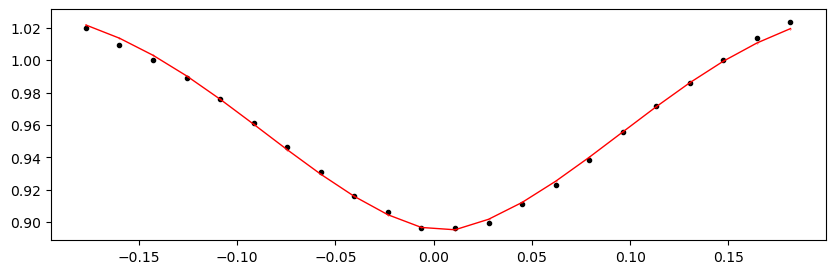

2131.577632 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.26it/s]


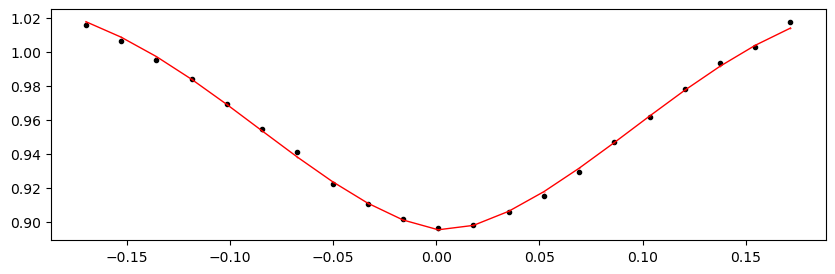

2131.9844279999998 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.93it/s]


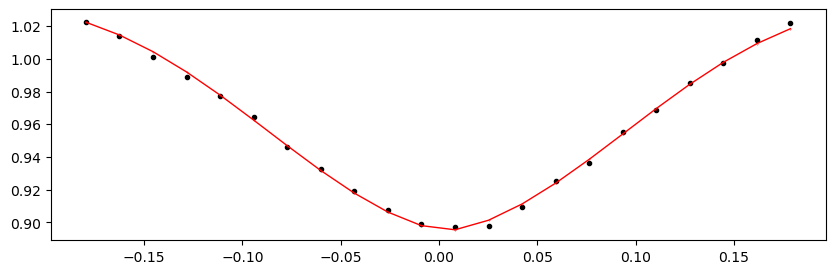

2132.391224 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.90it/s]


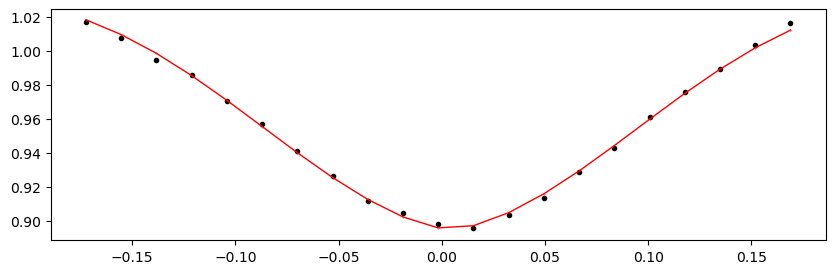

2132.79802 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.58it/s]


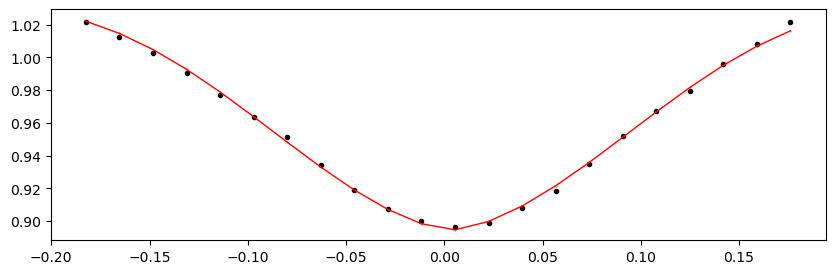

2133.204816 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.11it/s]


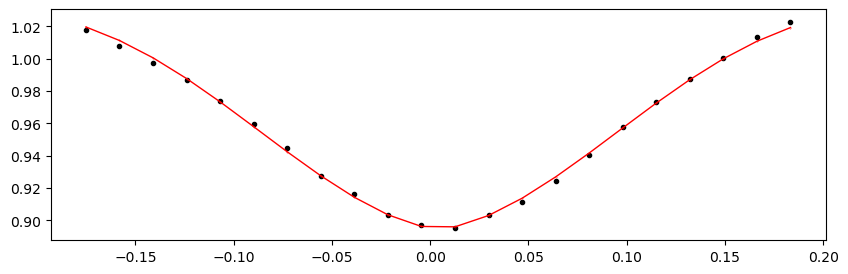

2133.611612 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.26it/s]


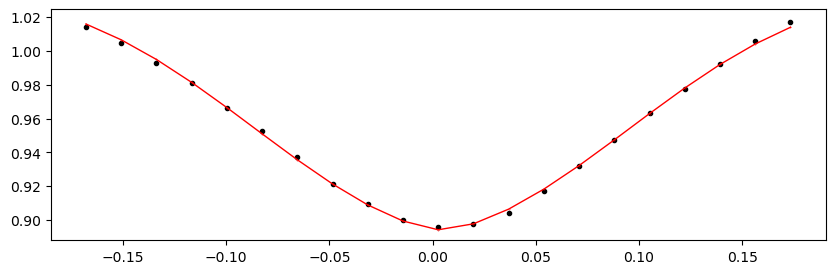

2134.018408 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.88it/s]


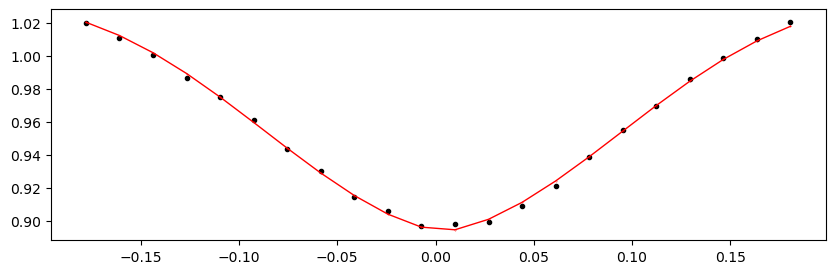

2134.425204 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.23it/s]


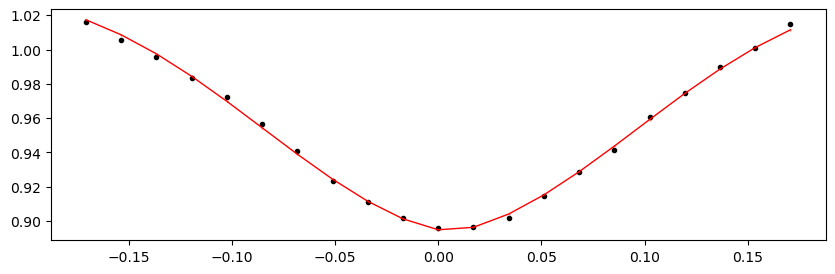

2134.832 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 254.69it/s]


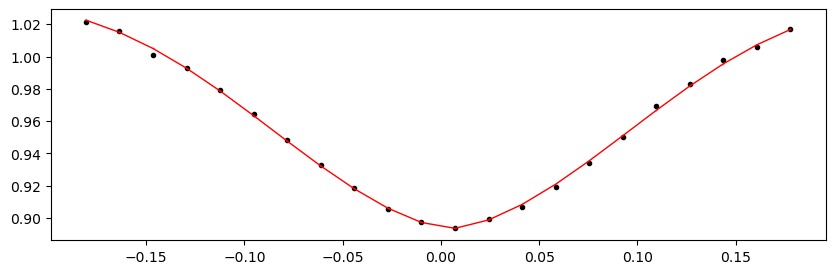

2135.238796 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.11it/s]


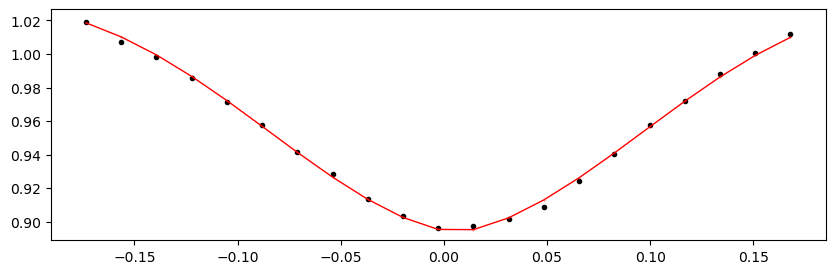

2135.645592 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 259.99it/s]


2136.052388 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 263.74it/s]


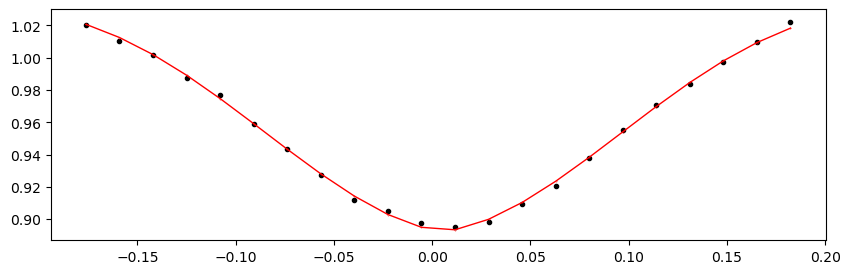

2136.4591840000003 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.78it/s]


2136.86598 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 257.75it/s]


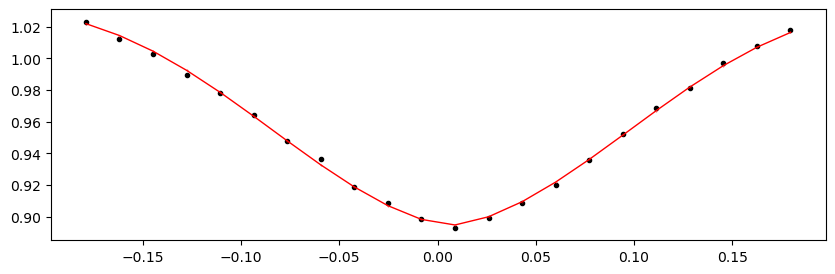

2137.272776 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 254.27it/s]


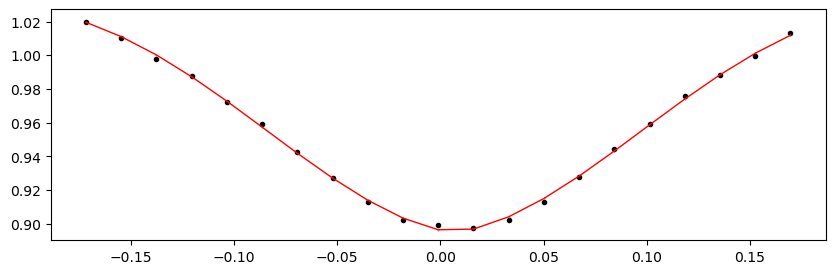

2137.679572 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.46it/s]


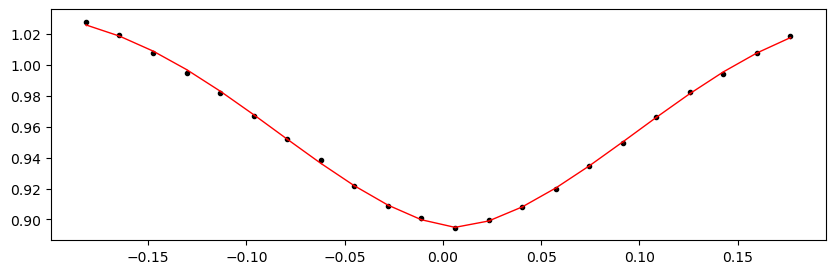

2138.086368 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 247.74it/s]


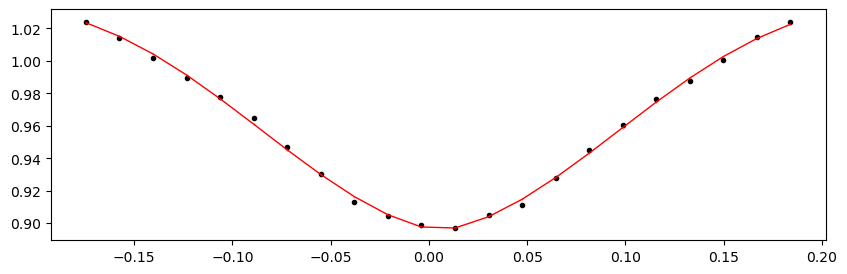

2138.493164 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 234.89it/s]


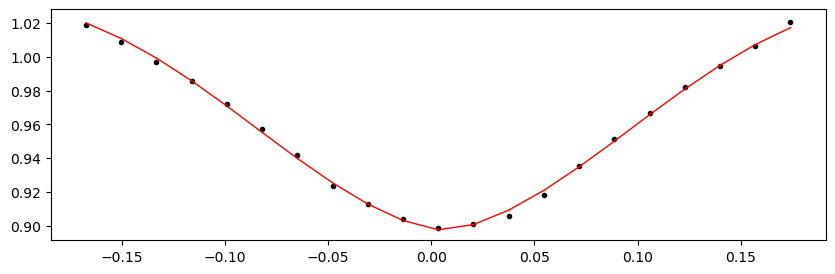

2138.8999599999997 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 256.44it/s]


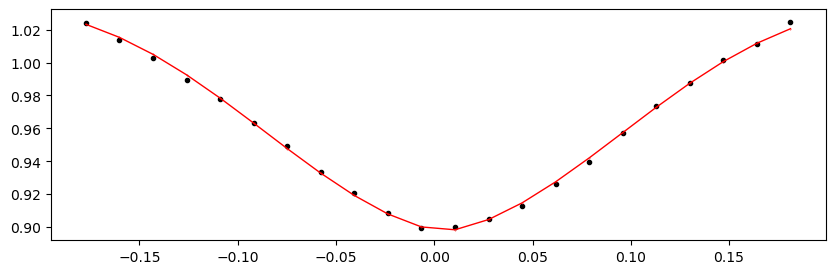

2139.306756 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 256.76it/s]


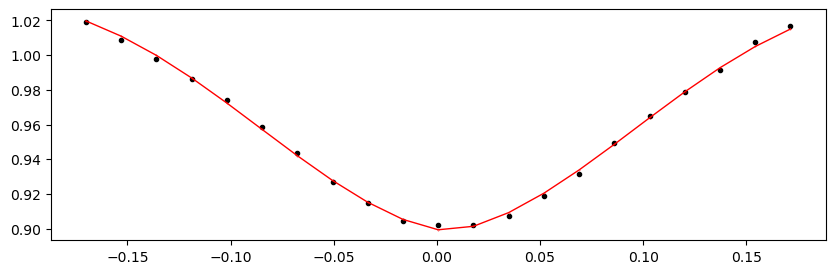

2139.713552 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 253.08it/s]


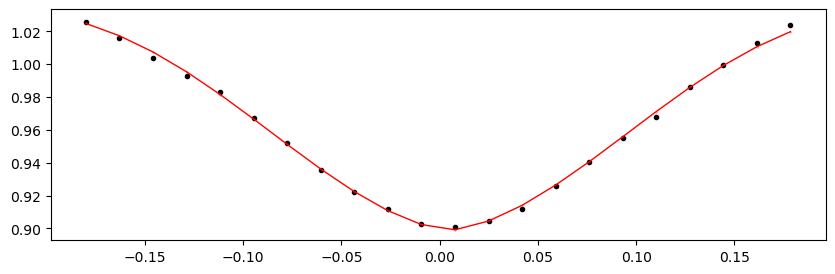

2140.120348 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 248.27it/s]


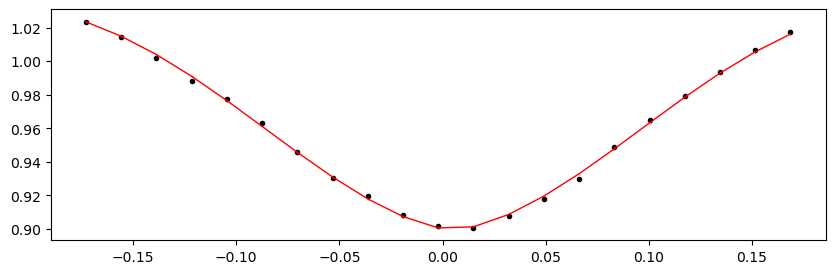

2140.527144 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 219.27it/s]


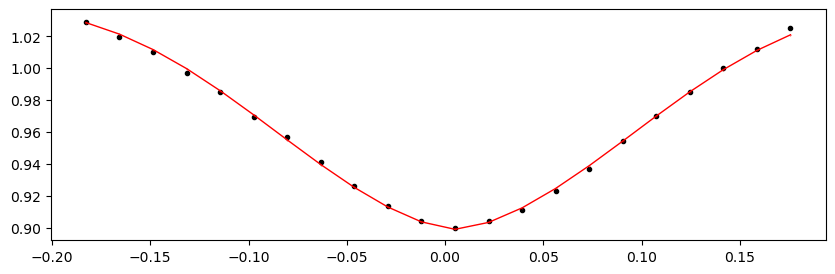

2140.93394 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.59it/s]


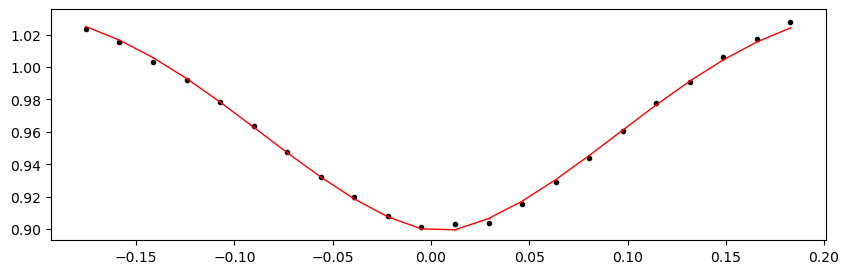

2141.340736 1.0358729768929278 -0.13914926145665393 0.22542871232877554


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.54it/s]


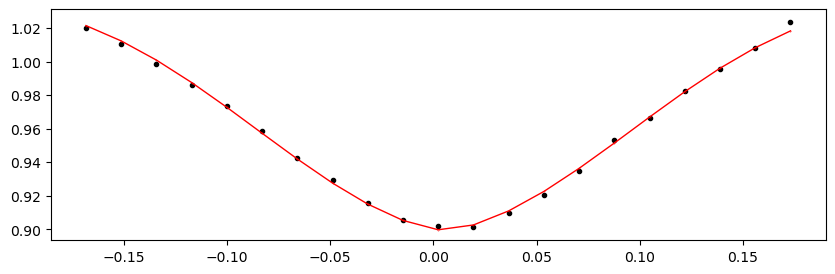

Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
1386.942152 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.32it/s]


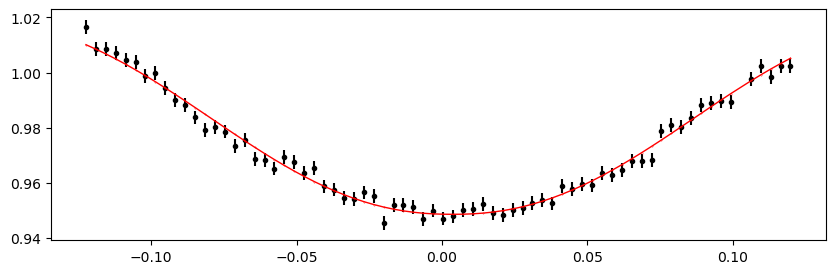

1387.348948 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.96it/s]


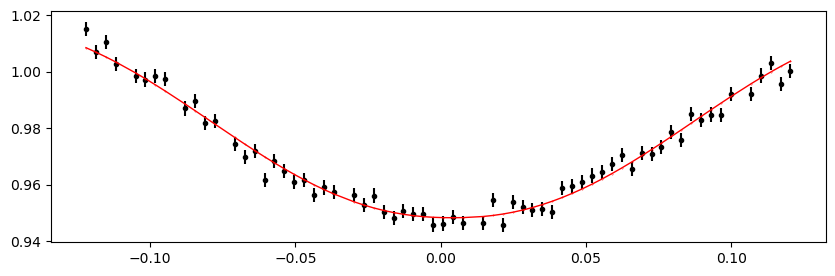

1387.755744 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.89it/s]


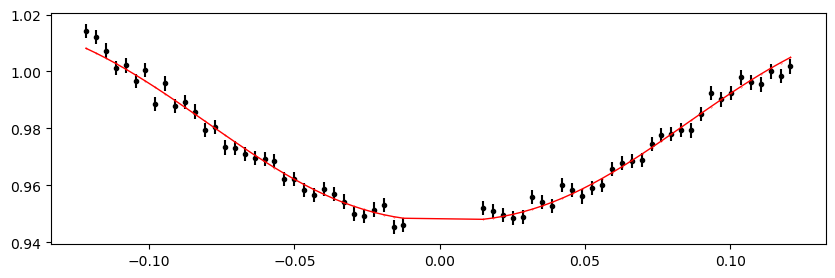

1388.16254 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.54it/s]


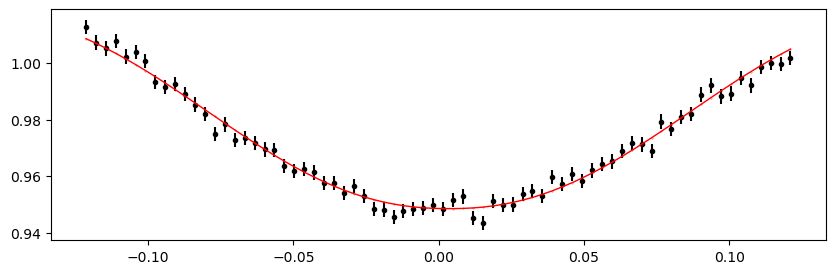

1388.569336 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.62it/s]


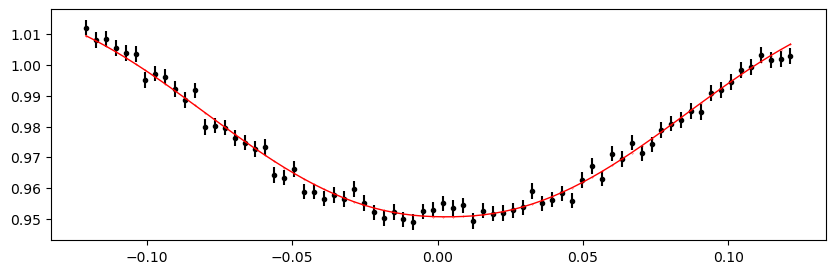

1388.9761320000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.73it/s]


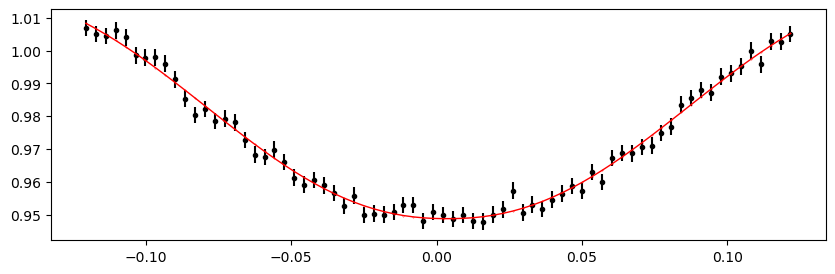

1389.3829280000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.69it/s]


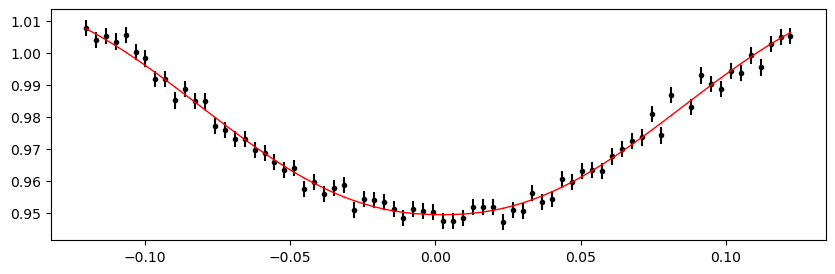

1389.7897240000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.29it/s]


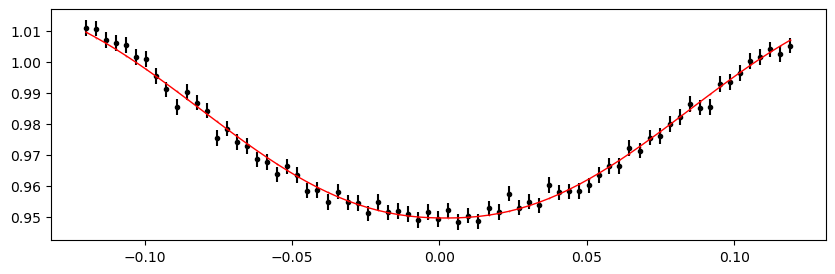

1390.1965200000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.01it/s]


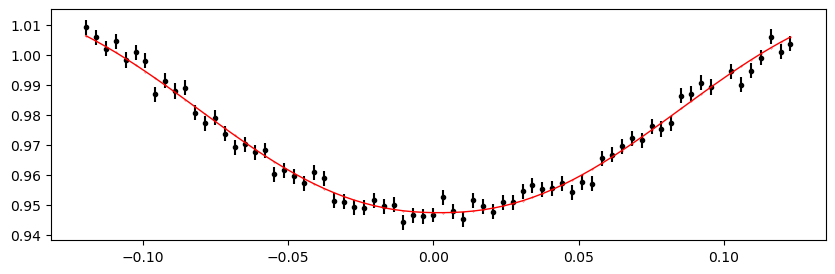

1390.6033160000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.53it/s]


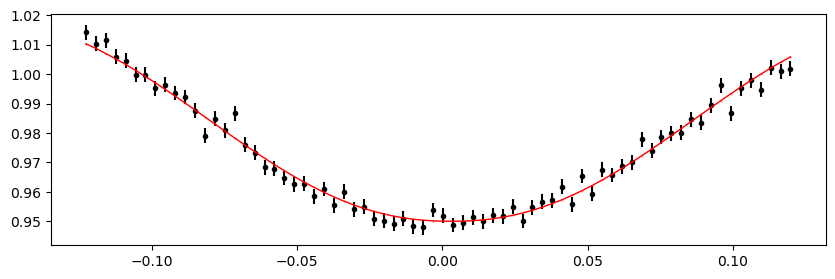

1391.0101120000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 374.34it/s]


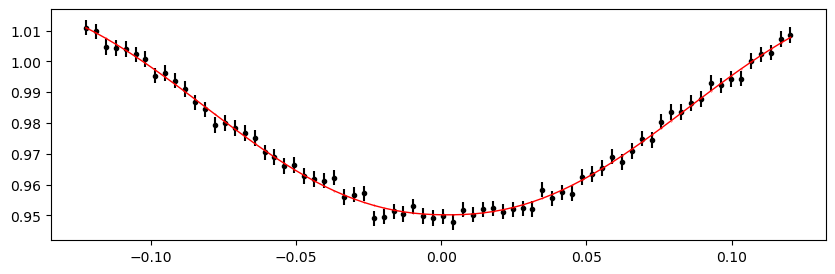

1391.4169080000001 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.23it/s]


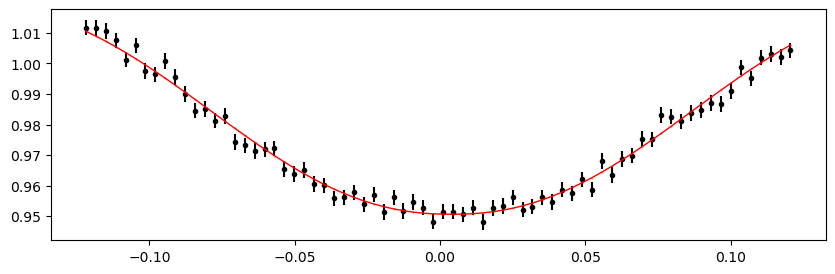

1391.8237040000001 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.11it/s]


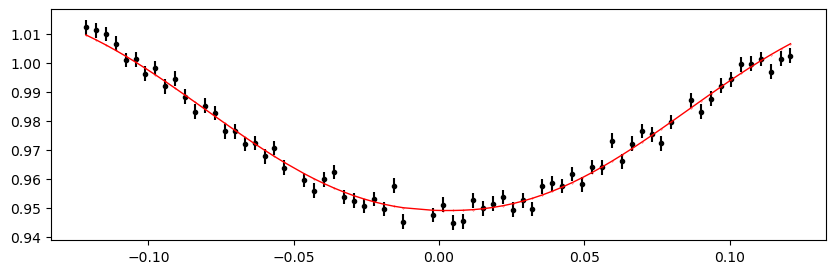

1392.2305000000001 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 368.58it/s]


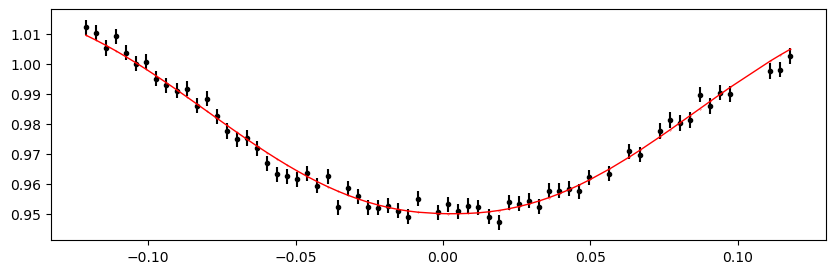

1392.637296 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 370.17it/s]


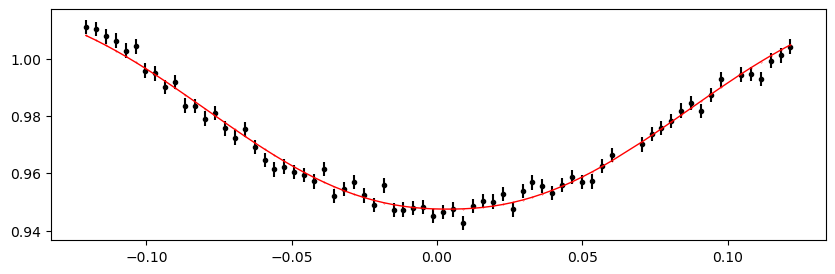

1393.044092 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.55it/s]


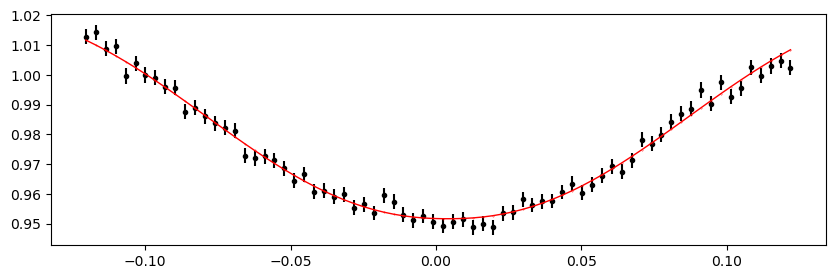

1393.450888 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.59it/s]


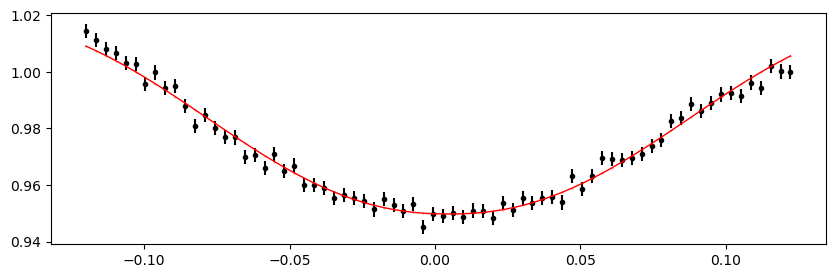

1393.857684 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.53it/s]


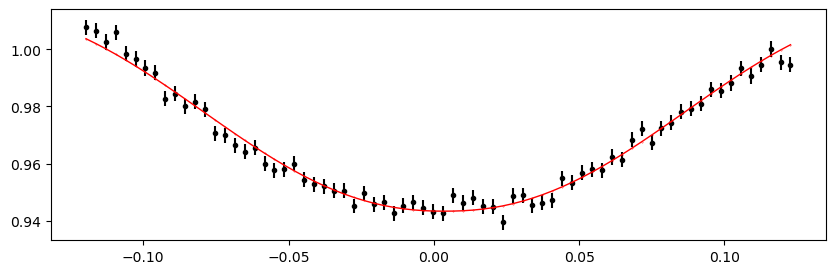

1394.26448 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.68it/s]


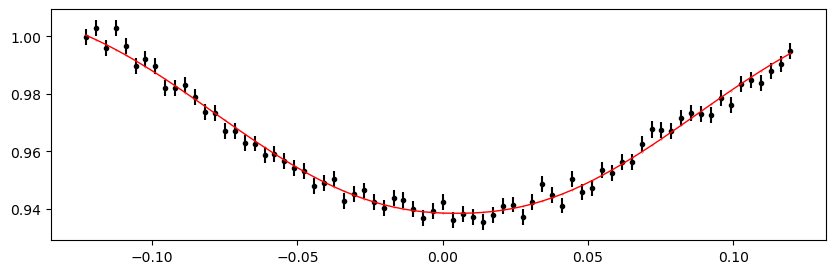

1396.7052560000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 369.49it/s]


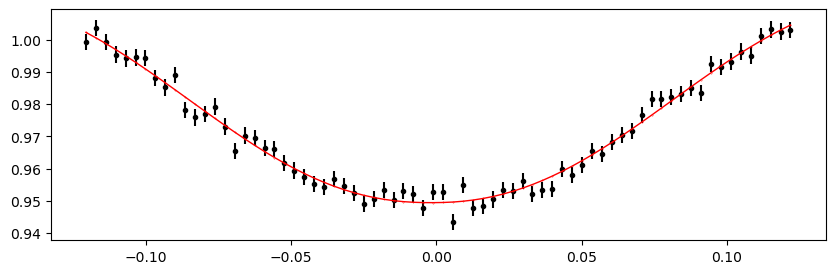

1397.1120520000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 374.33it/s]


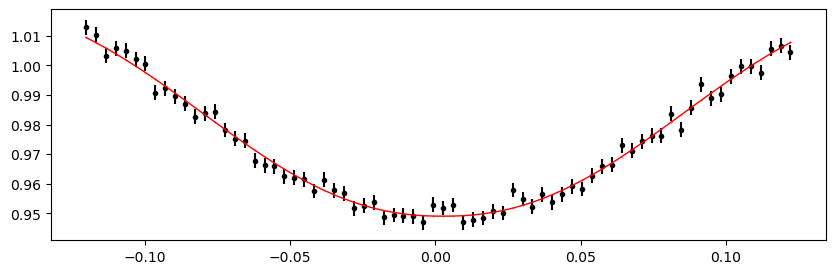

1397.5188480000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.16it/s]


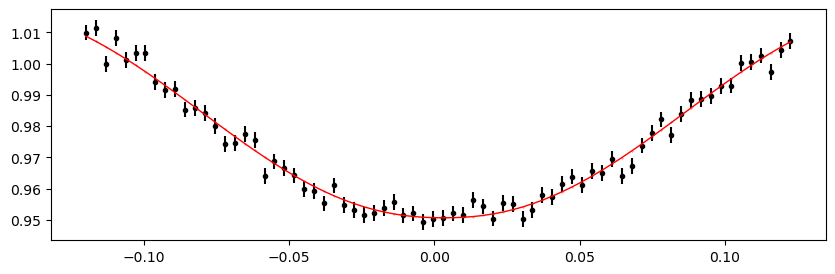

1397.9256440000001 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 369.02it/s]


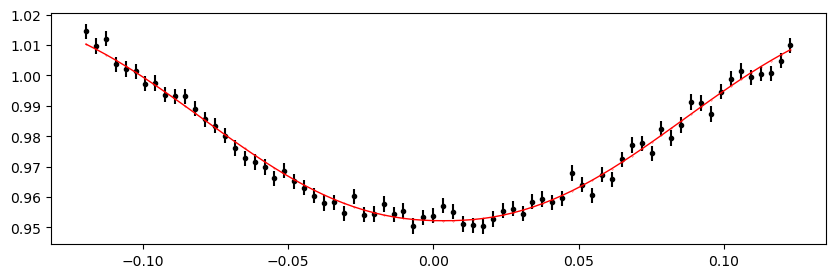

1398.3324400000001 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 369.44it/s]


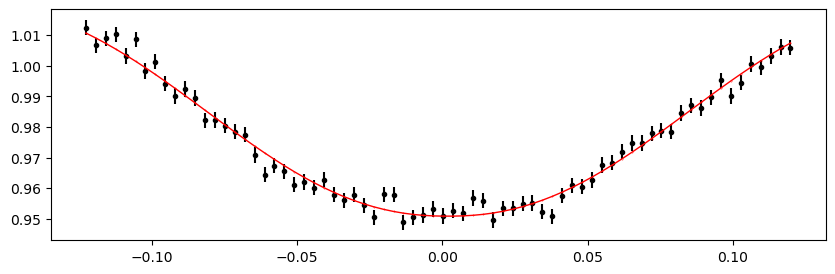

1398.7392360000001 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.34it/s]


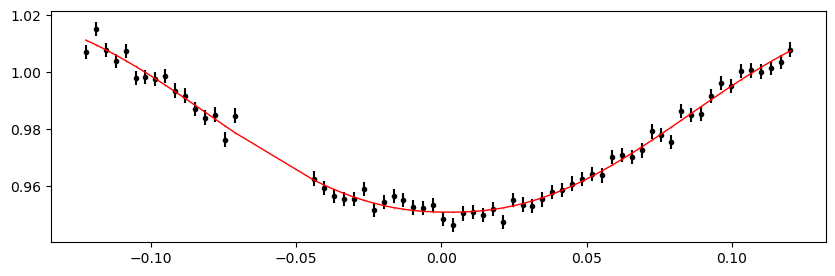

1399.146032 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.29it/s]


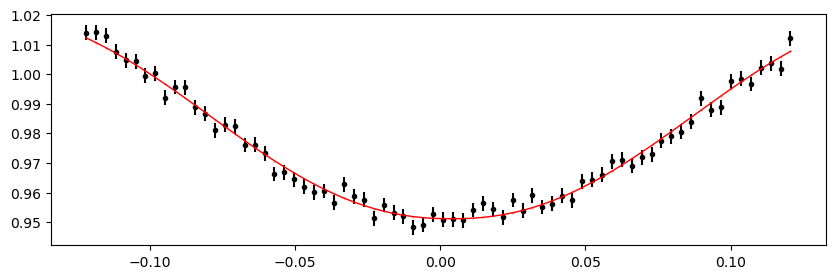

1399.552828 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.34it/s]


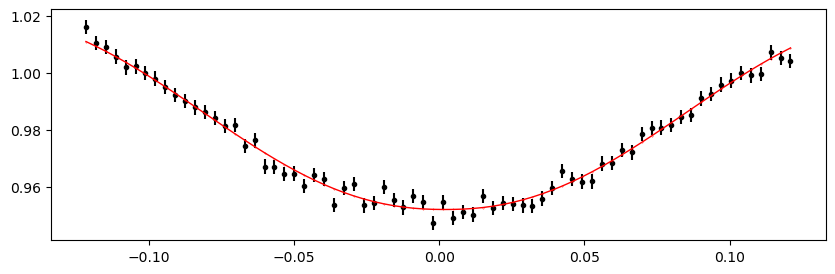

1399.959624 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.21it/s]


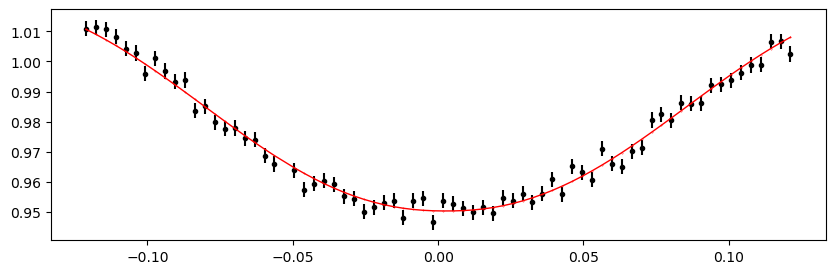

1400.36642 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.42it/s]


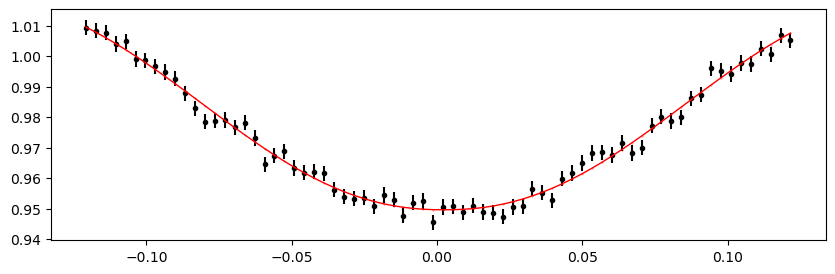

1400.773216 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.42it/s]


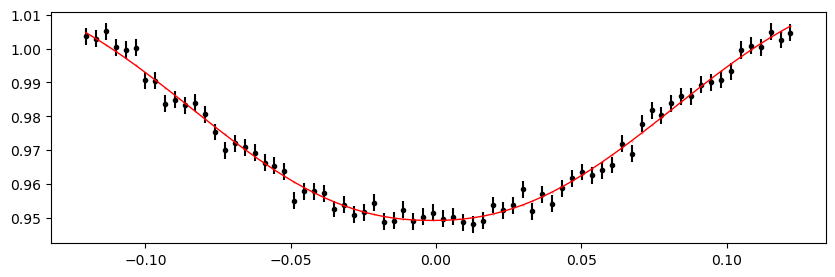

1401.180012 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.06it/s]


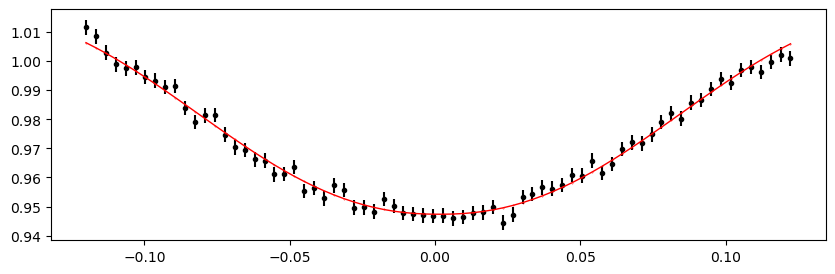

1401.586808 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.55it/s]


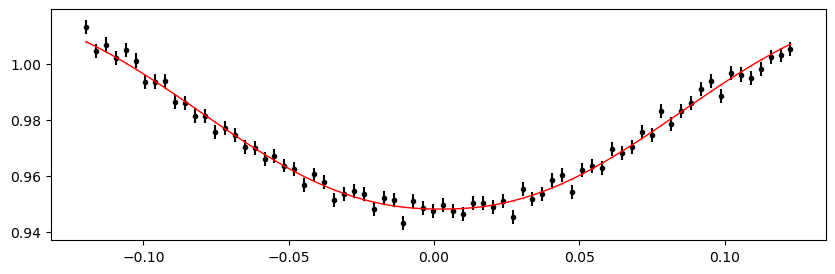

1401.9936040000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.72it/s]


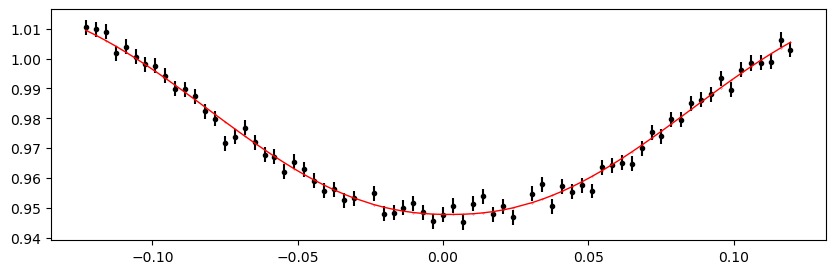

1402.4004000000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.17it/s]


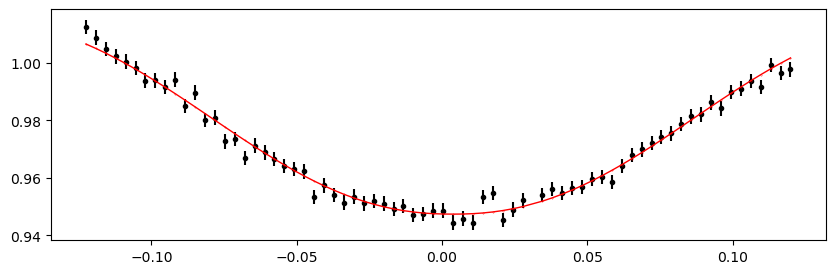

1402.8071960000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.85it/s]


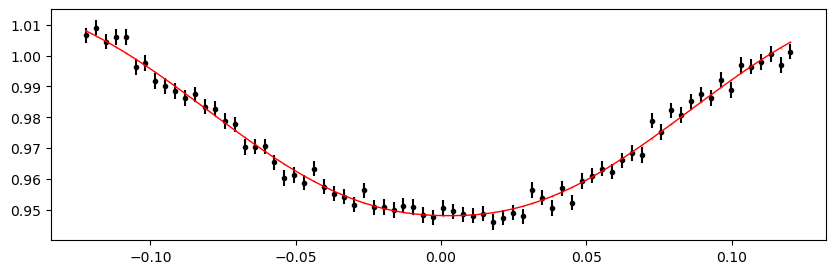

1403.2139920000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.37it/s]


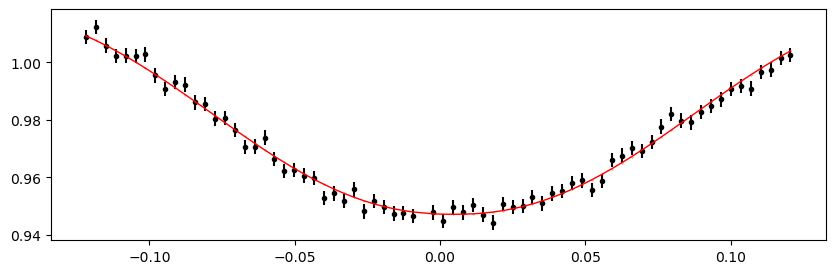

1403.6207880000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.40it/s]


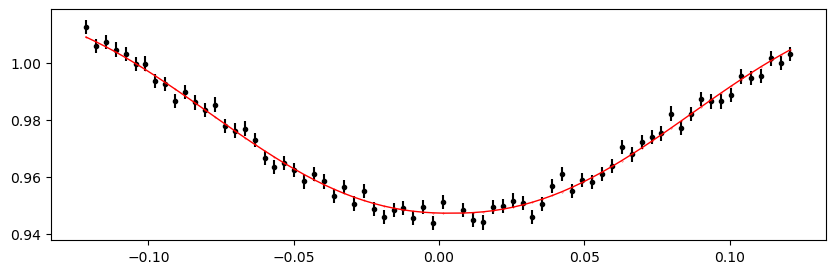

1404.0275840000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.37it/s]


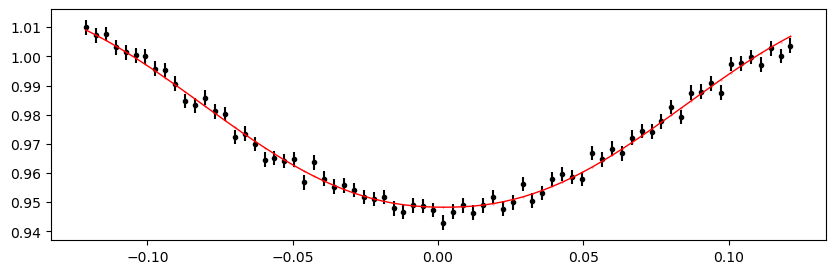

1404.4343800000001 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.21it/s]


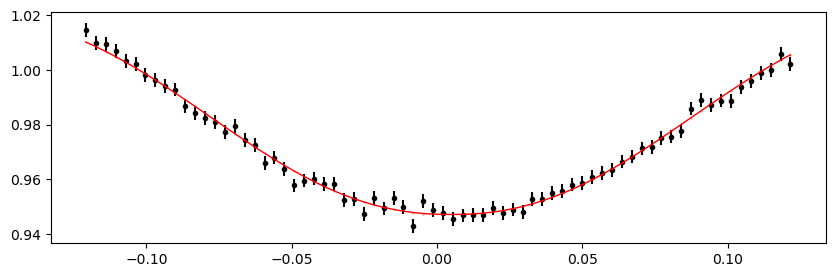

1404.8411760000001 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.18it/s]


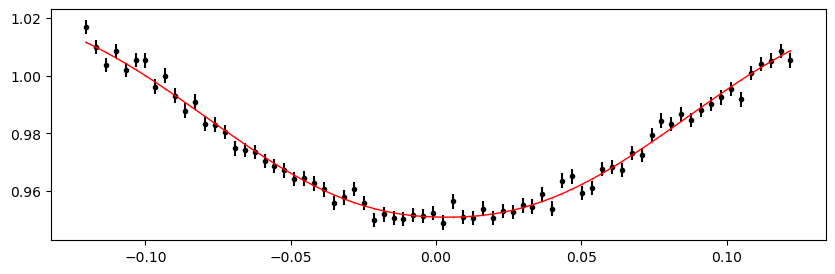

1405.2479720000001 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.17it/s]


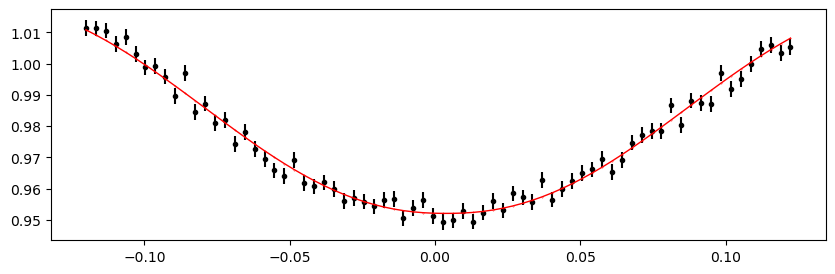

1405.654768 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.90it/s]


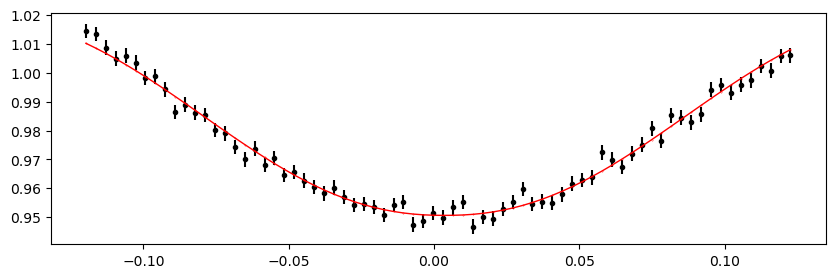

1406.061564 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.14it/s]


Time 2115.920584 does not have enough data points: 8
2116.32738 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.95it/s]


2116.734176 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.38it/s]


2117.140972 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.53it/s]


2117.5477680000004 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.30it/s]


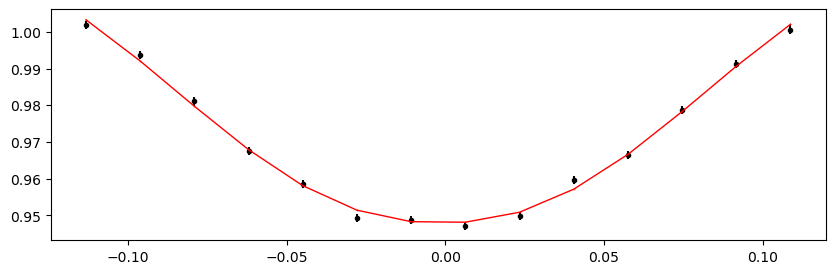

2117.954564 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.69it/s]


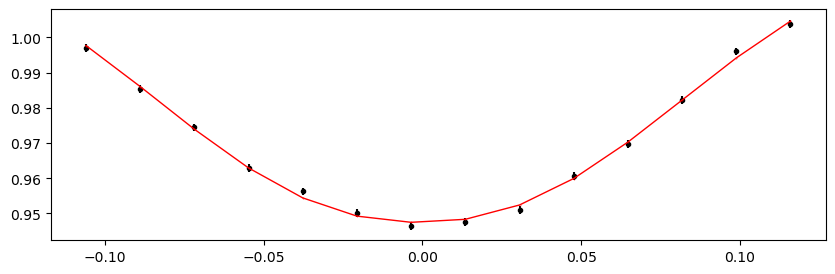

2118.36136 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.67it/s]


2118.768156 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.77it/s]


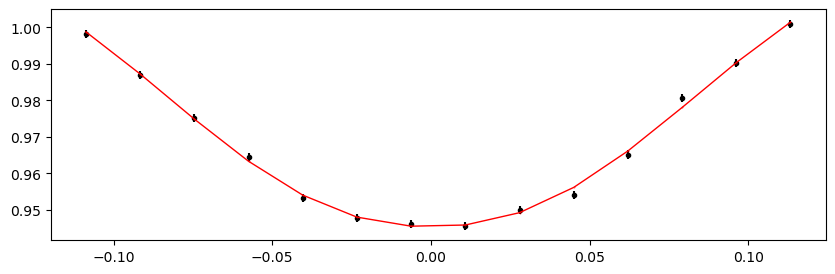

2119.1749520000003 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.31it/s]


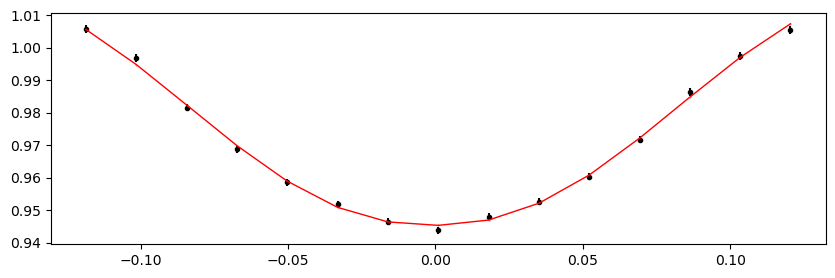

2119.581748 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.70it/s]


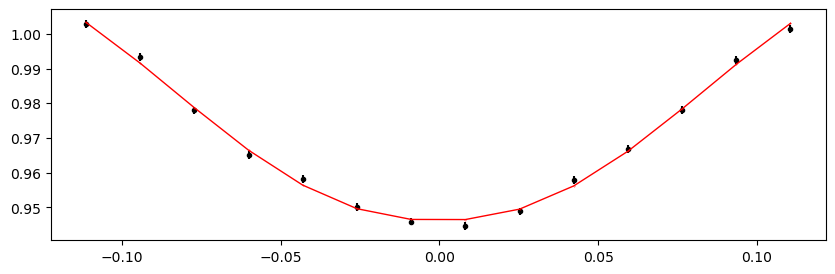

2119.9885440000003 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.82it/s]


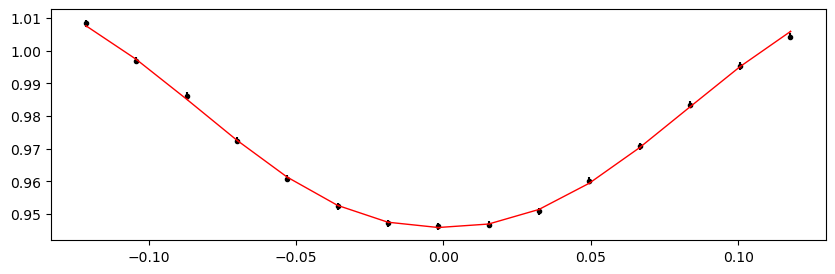

2120.39534 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.83it/s]


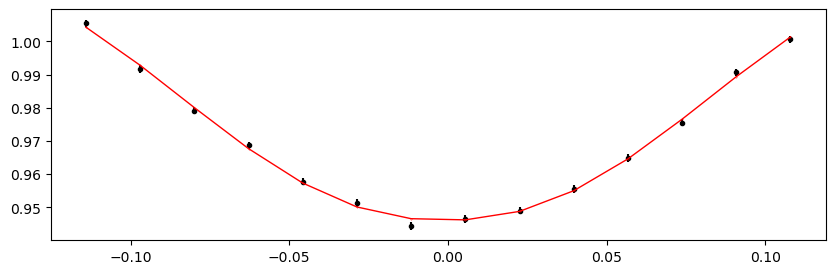

2120.8021360000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.91it/s]


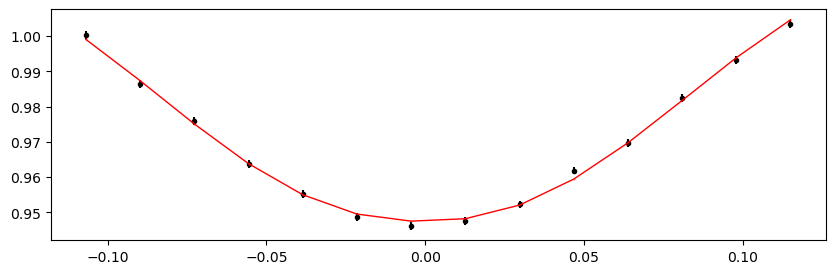

2121.208932 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.53it/s]


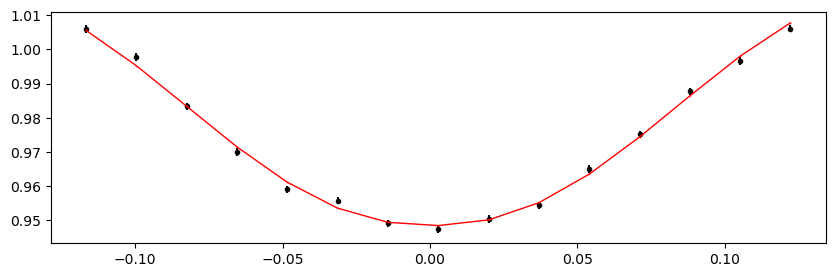

2121.615728 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.35it/s]


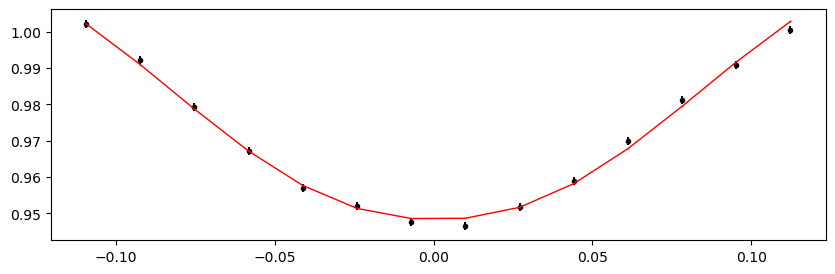

2122.022524 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.16it/s]


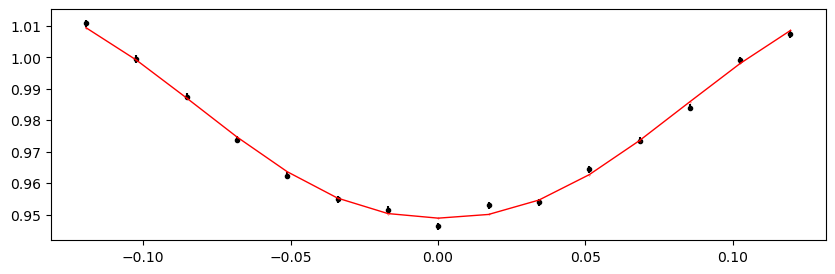

2122.42932 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.36it/s]


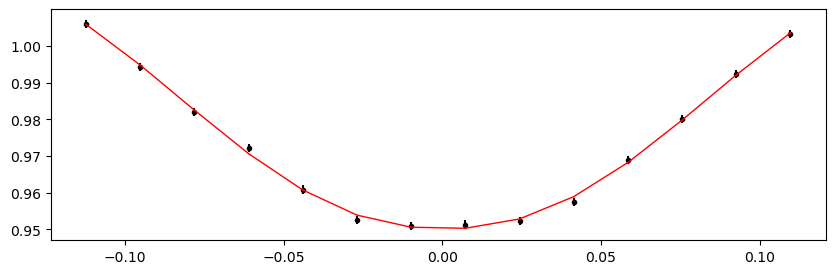

2122.836116 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.33it/s]


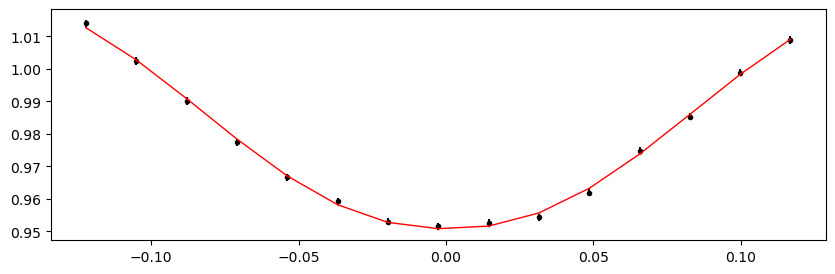

2123.242912 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.99it/s]


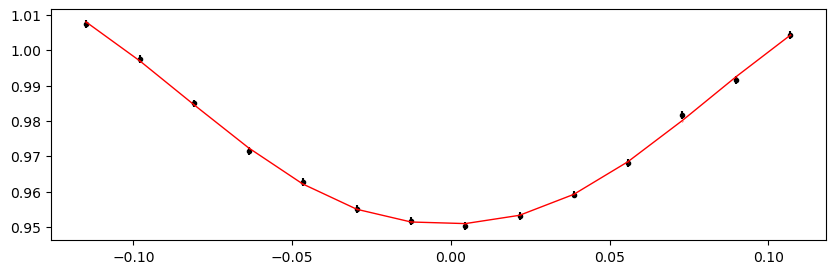

2123.649708 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.06it/s]


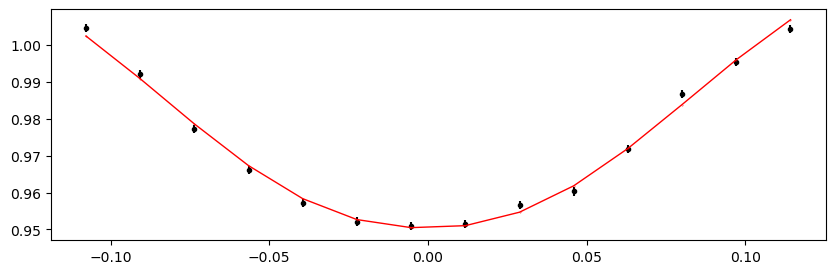

2124.056504 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.14it/s]


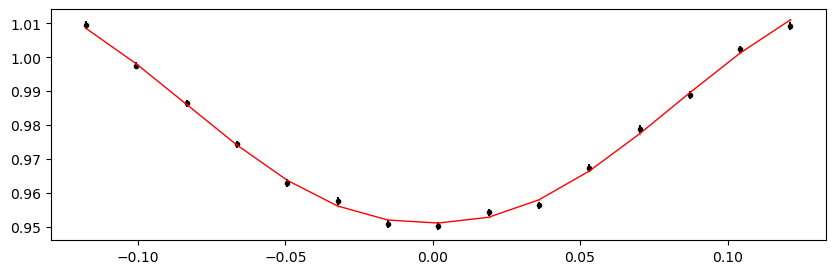

2124.4633000000003 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.87it/s]


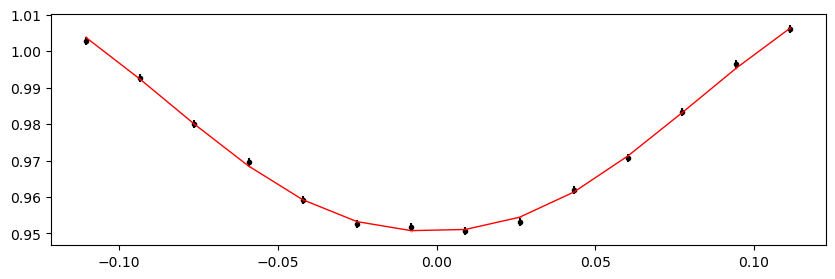

2124.870096 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.65it/s]


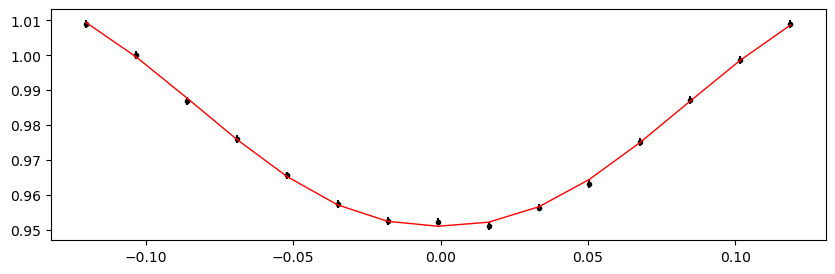

2125.276892 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.99it/s]


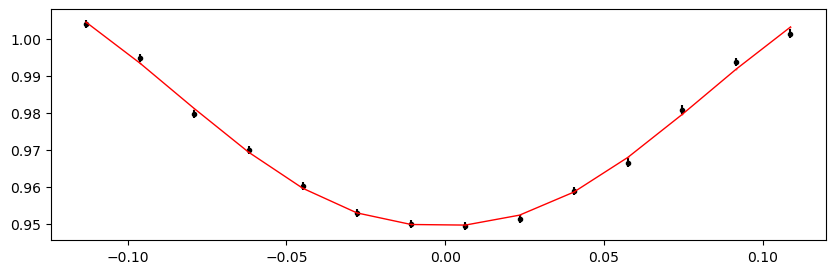

2125.683688 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.42it/s]


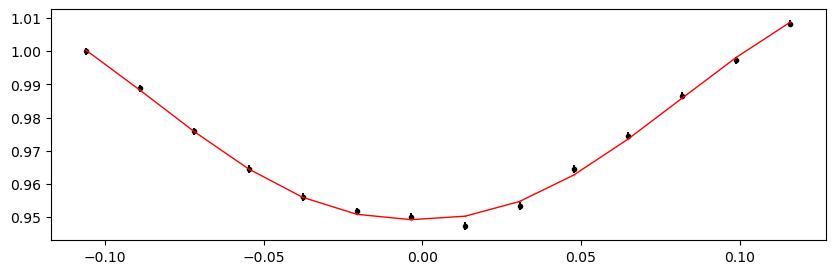

2126.0904840000003 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.19it/s]


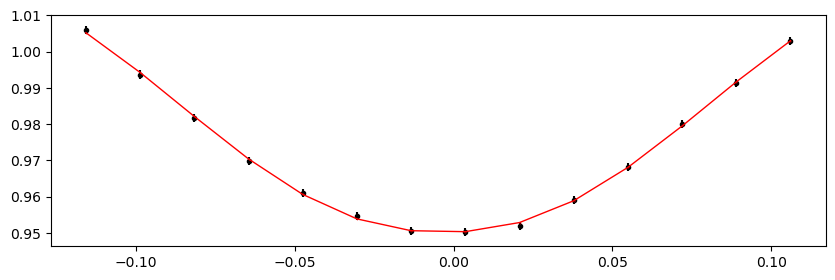

2126.49728 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.12it/s]


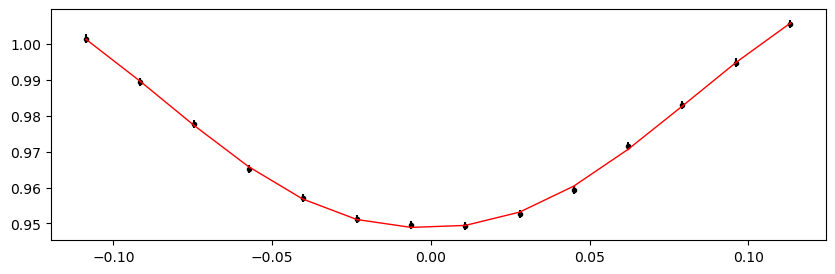

2126.9040760000003 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.94it/s]


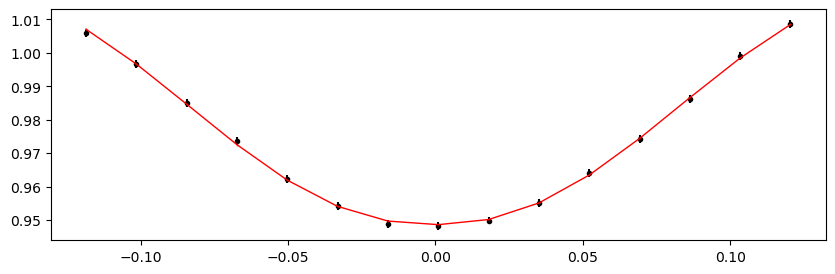

2127.310872 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.36it/s]


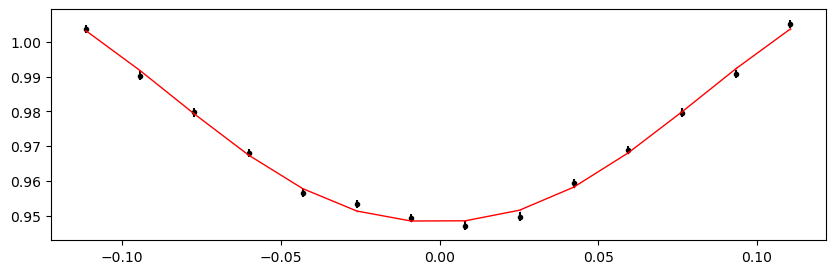

2130.56524 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.24it/s]


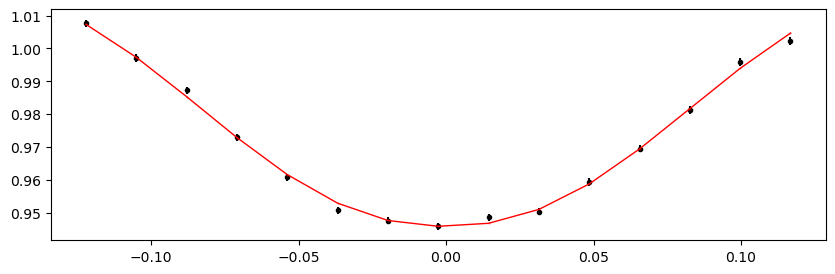

2130.972036 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.19it/s]


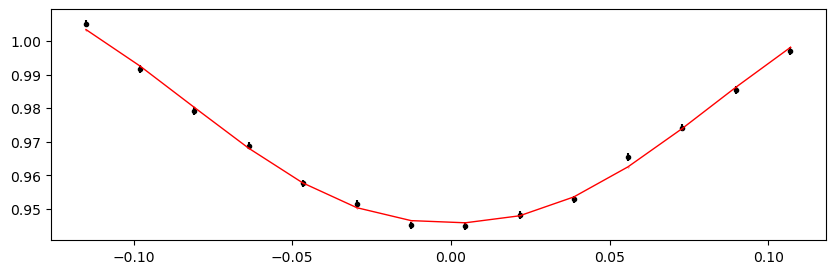

2131.3788320000003 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.08it/s]


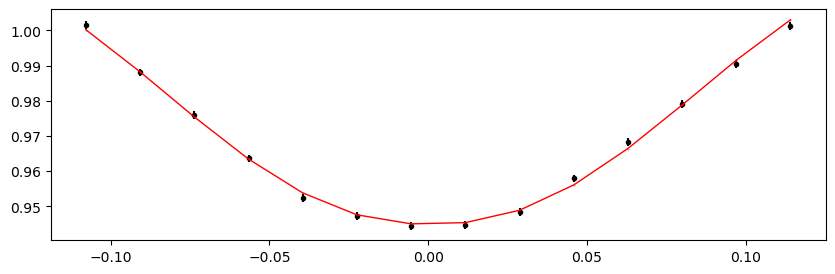

2131.785628 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.38it/s]


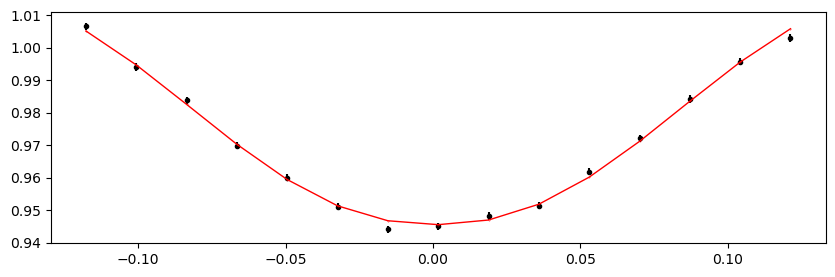

2132.192424 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.36it/s]


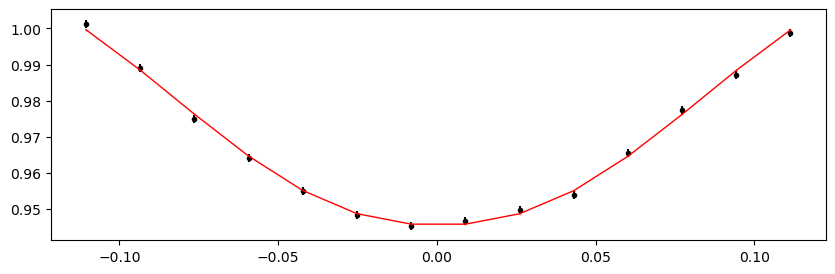

2132.59922 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.96it/s]


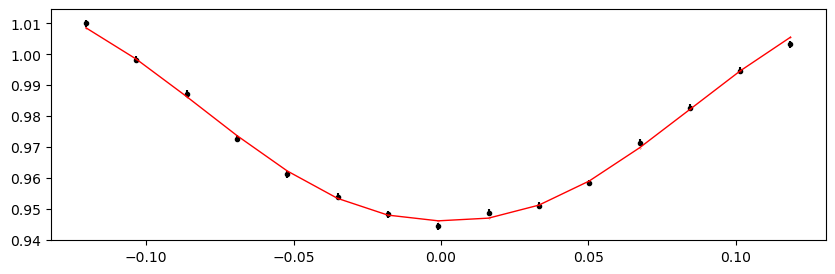

2133.0060160000003 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.04it/s]


2133.412812 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.81it/s]


2133.8196080000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.97it/s]


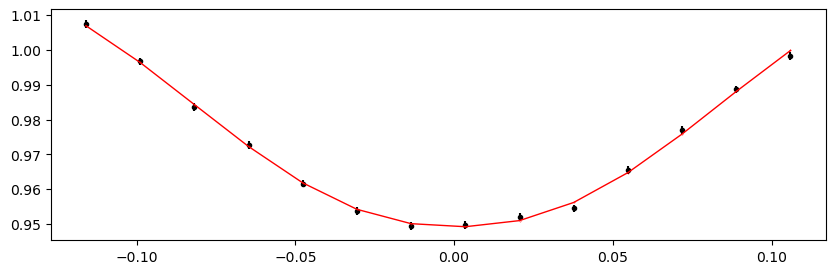

2134.226404 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.27it/s]


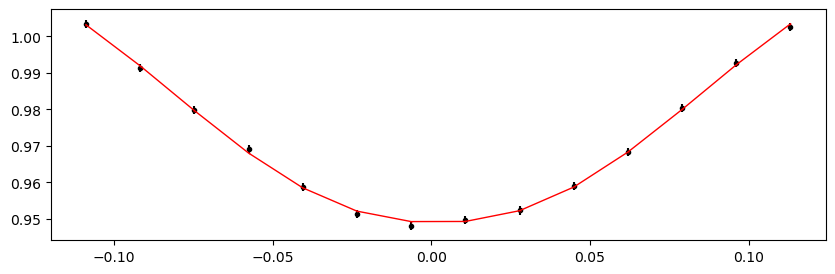

2134.6332 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.31it/s]


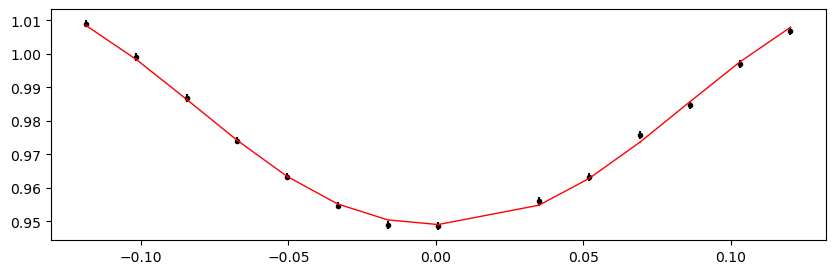

2135.039996 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.55it/s]


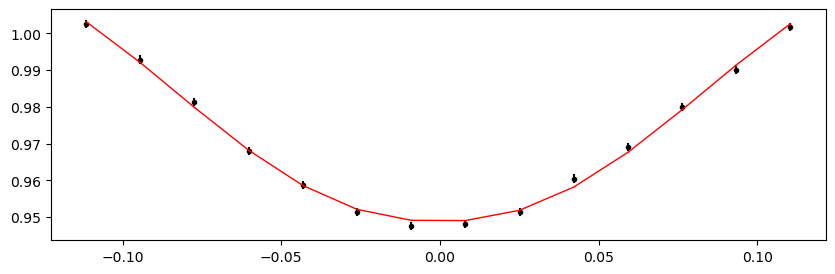

2135.446792 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.39it/s]


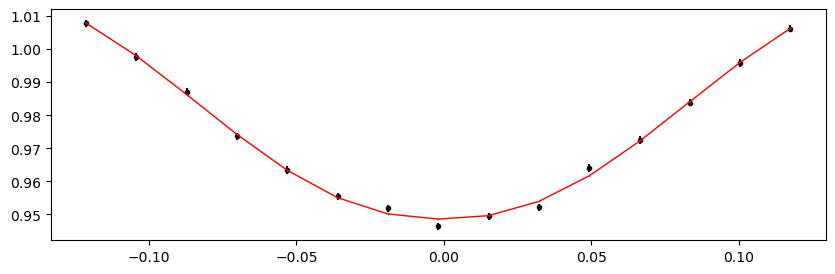

2135.853588 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.41it/s]


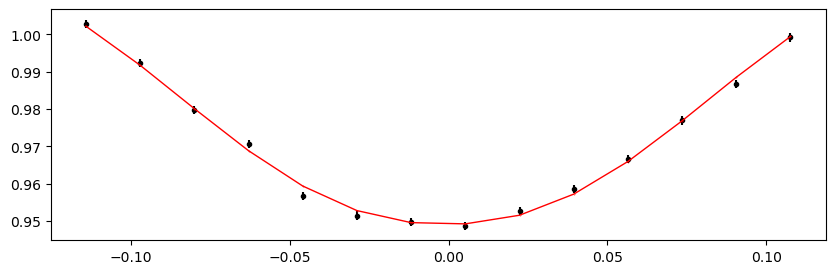

2136.260384 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.39it/s]


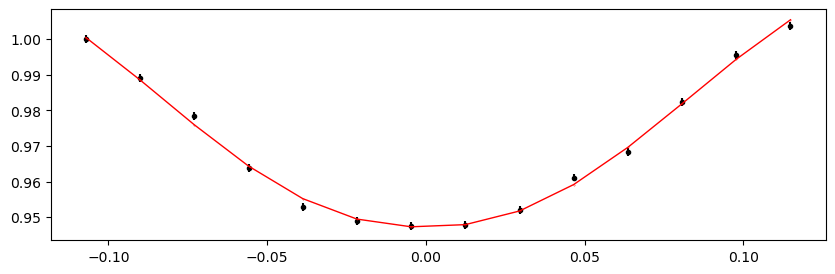

2136.6671800000004 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.89it/s]


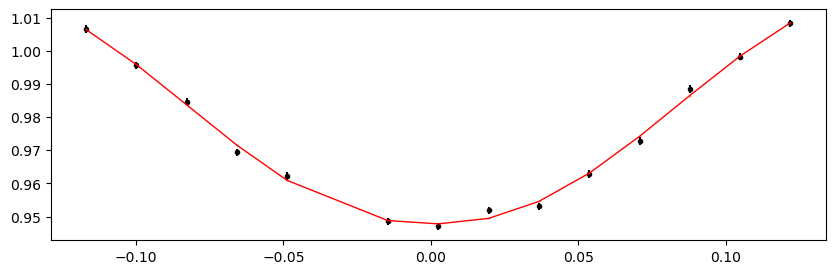

2137.073976 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.84it/s]


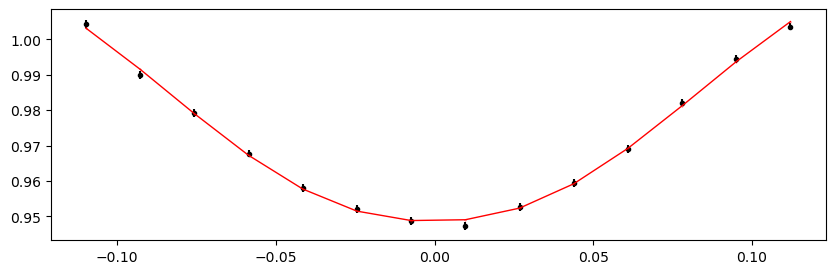

2137.480772 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.42it/s]


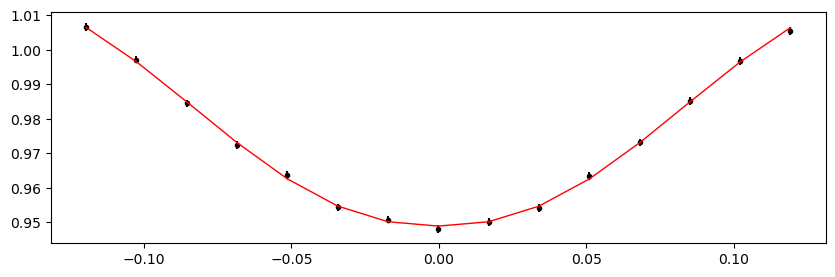

2137.887568 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.25it/s]


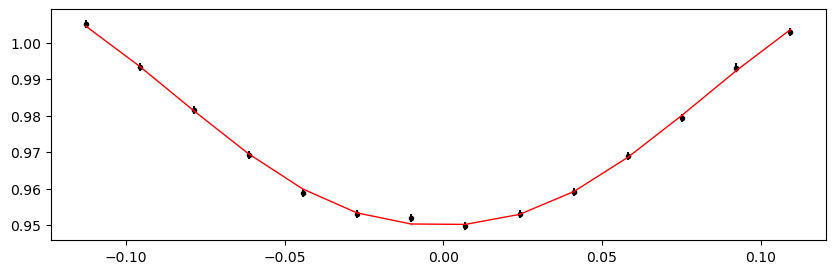

2138.2943640000003 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.46it/s]


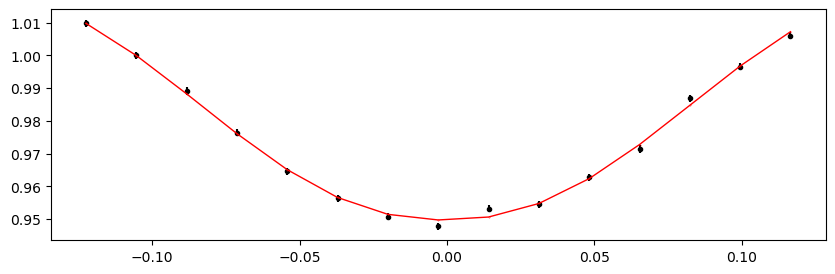

2138.70116 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.97it/s]


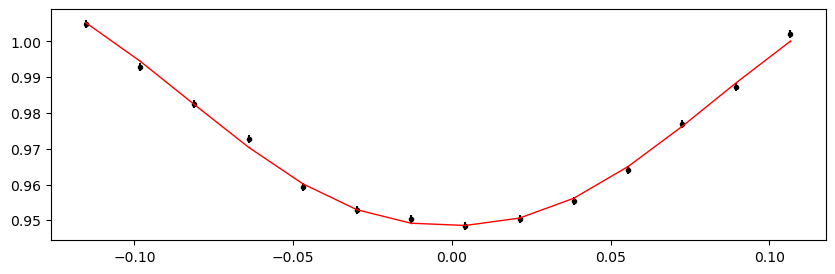

2139.107956 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.12it/s]


2139.514752 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.50it/s]


2139.9215480000003 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.57it/s]


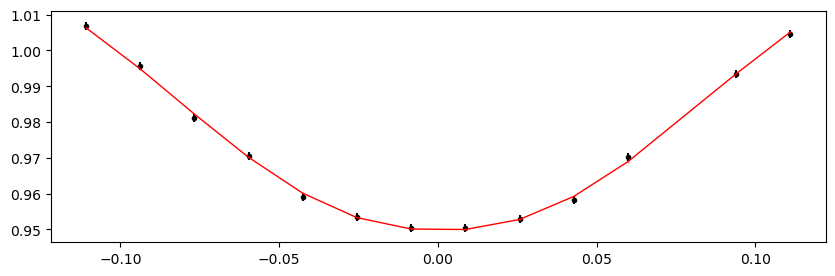

2140.328344 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.62it/s]


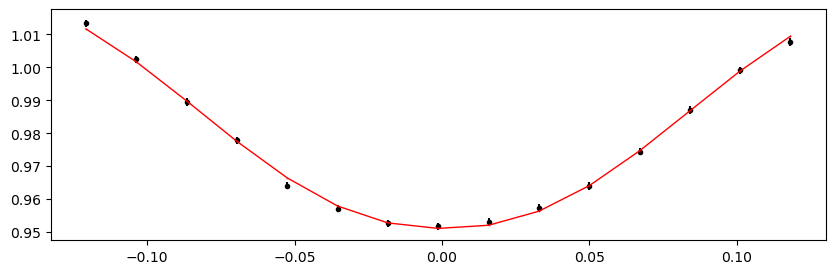

2140.7351400000002 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.69it/s]


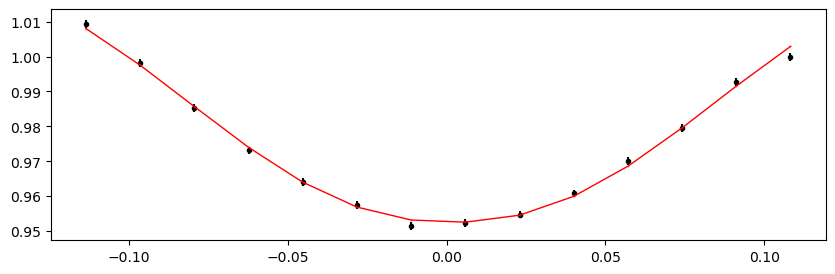

2141.141936 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.96it/s]


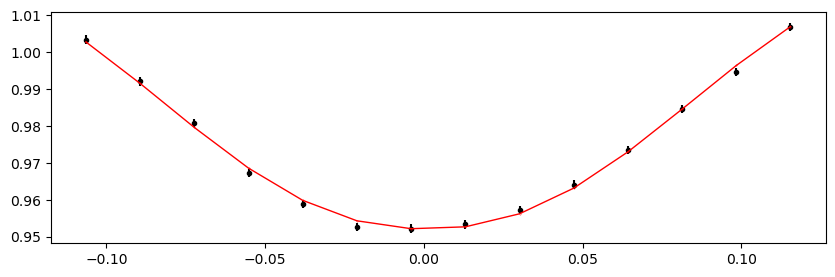

In [78]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=18, 
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"

# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=12,  # accomodate TESS-SPOC 
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")


Fitting individual secondary eclipses...
Creating new manifest file
1386.12856 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.33it/s]


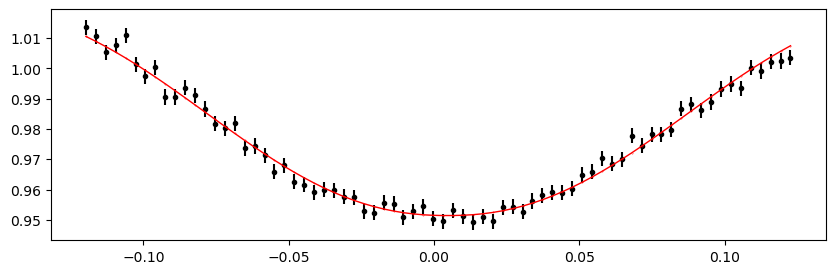

1386.535356 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.74it/s]


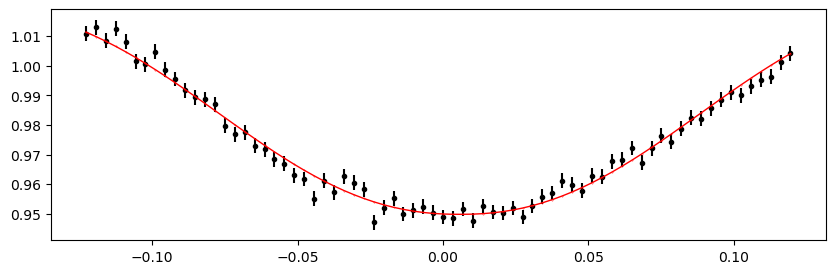

1386.942152 1.0230420602910246 -0.07427046987659028 -0.26743441661920664


 15%|████████▍                                               | 1513/10000 [00:04<00:21, 394.32it/s]Traceback (most recent call last):
  File "C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\emcee\ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "C:\dev\_juypter\PH_TESS_LightCurveViewer\eb_with_diff_sb_period\etv\etv_functions.py", line 535, in log_probability_fitting
    lnp = lp + log_likelihood_fitting(theta, x, y, yerr, mean_d, mean_Tau)
  File "C:\dev\_juypter\PH_TESS_LightCurveViewer\eb_with_diff_sb_period\etv\etv_functions.py", line 526, in log_likelihood_fitting
    return -0.5 * np.sum((y - model) ** 2 / (yerr**2))
  File "C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\numpy\core\fromnumeric.py", line 2172, in _sum_dispatcher
    def _sum_dispatcher(a, axis=None, dtype=None, out=None, keepdims=None,
KeyboardInterrupt
 15%|████████▌                                               | 1518/10000 [00:

emcee: Exception while calling your likelihood function:
  params: [ 1.02180376 -0.07254655  0.00438726]
  args: (array([-0.12246053, -0.1190463 , -0.11563208, -0.11221785, -0.10880362,
       -0.10538939, -0.10197517, -0.09856094, -0.09514671, -0.09173248,
       -0.08831826, -0.08490403, -0.0814898 , -0.07807557, -0.07466135,
       -0.07124712, -0.06783289, -0.06441866, -0.06100444, -0.05759021,
       -0.05417598, -0.05076175, -0.04734753, -0.0439333 , -0.04051907,
       -0.03710485, -0.03369062, -0.03027639, -0.02686216, -0.02344794,
       -0.02003371, -0.01661948, -0.01320525, -0.00979103, -0.0063768 ,
       -0.00296257,  0.00045166,  0.00386588,  0.00728011,  0.01069434,
        0.01410856,  0.01752279,  0.02093702,  0.02435125,  0.02776547,
        0.0311797 ,  0.03459393,  0.03800815,  0.04142238,  0.04483661,
        0.04825084,  0.05166506,  0.05507929,  0.05849352,  0.06190775,
        0.06532197,  0.0687362 ,  0.07215043,  0.07556465,  0.07897888,
        0.08239311,  0

KeyboardInterrupt: 

## ETV O-C plot

In [79]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### O-C Plot, Zoom In

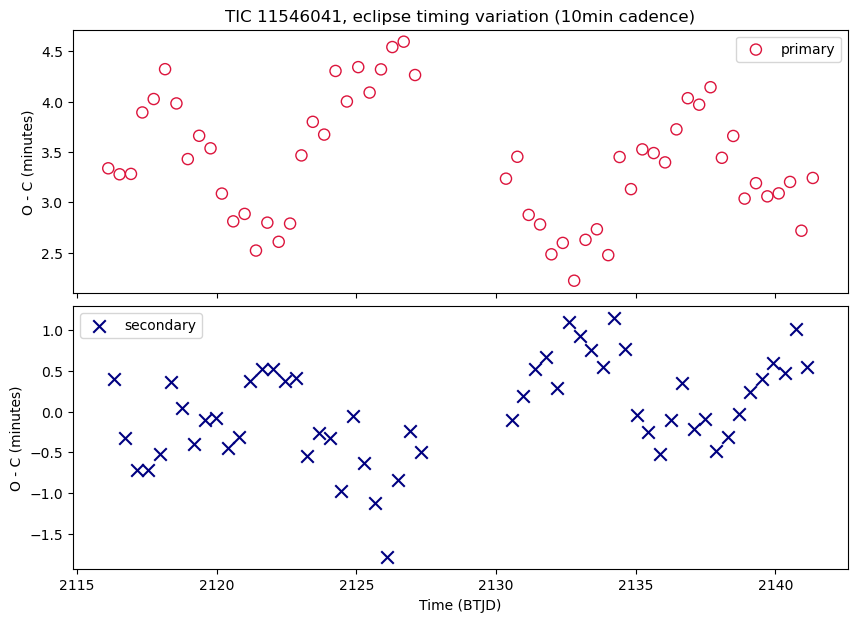

In [84]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1300, 1450),
    (2100, 2200),
]
title_suffix = "eclipse timing variation"

def tweak_axs_list(axs_list):
    axs_list[0][0].set_ylim(0, 7);
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    ax = axs_list[0][0]
    ax.set_title(f"{ax.get_title()} (2min cadence)")
    ax = axs_list[1][0]
    ax.set_title(f"{ax.get_title()} (10min cadence)")
    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
    
        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]
        
        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]
              
        axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'], 
                       marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        # axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'], 
        #                 lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
        
        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]
        
            axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
                           marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            # axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
            #                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
        
        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();
        
        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)
        
        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

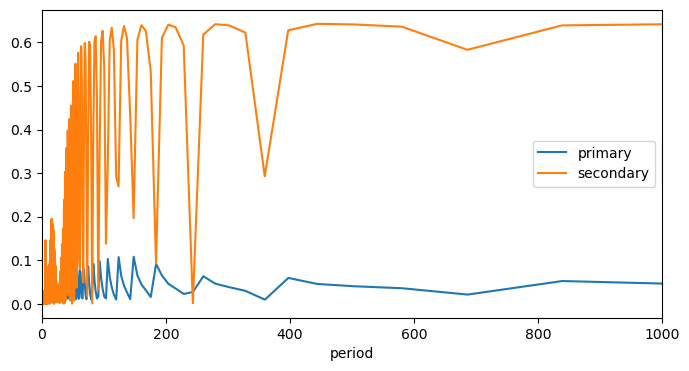

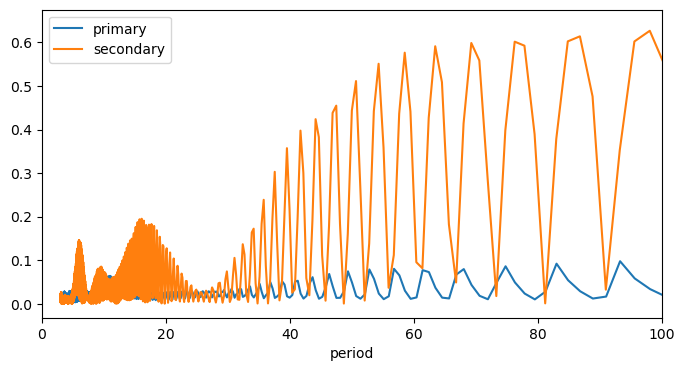

In [83]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 1000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 100)
    plt.show()

## Results Summary

In [85]:
# FILL-IN the ETV results / comments
has_etv = "Y?"
comments = "Possible ETV for both primary and secondary in 2 separate sectors. Short-term (~6 d) change and long-term (700+ d) change. The trend of primary is opposite of the one of secondary."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                                             11546041
has_etv                                                                                                                               Y?
comments     Mightbe ETV for both primary and secondary in 2 separate sectors. The trend of primary is opposite of the one of secondary.
period                                                                                                                          0.406796
depth_pct_p                                                                                                                        13.91
depth_pct_s                                                                                                                         7.43
epoch_p                                                                                                                      1385.920564
epoch_s                                                                                                                      1385.721764
num_sectors                                                                                                                            2
time_span                                                                                                                         757.28
time_start                                                                                                                       1385.94
time_end                                                                                                                         2143.22


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
11546041,Y?,Mightbe ETV for both primary and secondary in 2 separate sectors. The trend of primary is opposite of the one of secondary.,0.406796,13.91,7.43,1385.920564,1385.7217640000001,2,757.28,1385.94,2143.22

